# 参考資料
ベース
https://signate.jp/competitions/402/discussions/lgbm-baseline-except-text-vs-include-text-lb07994-1

1位解法
https://signate.jp/competitions/402/discussions/120210204

やりきれなかったこと

地域・言語圏のカラム、クラスタとの距離、PseudoLabesing、特徴量選択の他の手法、言語処理の違いによるスタッキング

In [233]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')
import os

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# データの読み込み

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df

,id,goal,country,duration,category1,category2,html_content,state
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1
...,...,...,...,...,...,...,...,...
10540,10540,1-1000,GB,30,film & video,experimental,"<div class=""contents""><div><h1 class=""page-anc...",0
10541,10541,1-1000,US,29,journalism,web,"<div class=""contents""><div><p>This past Novemb...",0
10542,10542,19001-20000,US,33,journalism,web,"<div class=""contents""><div><p><span class=""bol...",0
10543,10543,1-1000,FR,30,comics,comic books,"<div class=""contents""><div><h1 class=""page-anc...",1


In [5]:
test_df

,id,goal,country,duration,category1,category2,html_content
0,10545,1-1000,US,60,dance,performances,"<div class=""contents""><div><p>We are presentin..."
1,10546,8001-9000,US,30,crafts,printing,"<div class=""contents""><div><a href=""http://dum..."
2,10547,9001-10000,US,60,design,product design,"<div class=""contents""><div><div class=""templat..."
3,10548,1001-2000,US,30,technology,software,"<div class=""contents""><div><p>This is my video..."
4,10549,4001-5000,US,59,technology,software,"<div class=""contents""><div><h1 class=""page-anc..."
...,...,...,...,...,...,...,...
10539,21084,9001-10000,US,30,food,drinks,"<div class=""contents""><div><p>Its time to get ..."
10540,21085,1-1000,US,29,food,small batch,"<div class=""contents""><div><p>I have been roas..."
10541,21086,1001-2000,US,27,crafts,pottery,"<div class=""contents""><div><p> I have ..."
10542,21087,2001-3000,US,30,design,graphic design,"<div class=""contents""><div><h1 class=""page-anc..."


In [190]:
# データの結合
all_df = pd.concat([train_df, test_df])
all_df.reset_index(drop=True, inplace=True)
all_df

,id,goal,country,duration,category1,category2,html_content,state
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0.0
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0.0
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0.0
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0.0
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1.0
...,...,...,...,...,...,...,...,...
21084,21084,9001-10000,US,30,food,drinks,"<div class=""contents""><div><p>Its time to get ...",NaN
21085,21085,1-1000,US,29,food,small batch,"<div class=""contents""><div><p>I have been roas...",NaN
21086,21086,1001-2000,US,27,crafts,pottery,"<div class=""contents""><div><p> I have ...",NaN
21087,21087,2001-3000,US,30,design,graphic design,"<div class=""contents""><div><h1 class=""page-anc...",NaN


# EDA

## 非目的変数

In [191]:
all_df["state"].value_counts()

1.0    5318
0.0    5227
Name: state, dtype: int64

## 欠損値

In [192]:
all_df.isnull().sum()

id                  0
goal                0
country             0
duration            0
category1           0
category2           0
html_content        0
state           10544
dtype: int64

## 型

In [193]:
all_df.dtypes

id                int64
goal             object
country          object
duration          int64
category1        object
category2        object
html_content     object
state           float64
dtype: object

## 統計量

In [194]:
all_df.describe()

,id,duration,state
count,21089.000000,21089.000000,10545.000000
mean,10544.000000,32.628195,0.504315
std,6088.014249,12.045661,0.500005
min,0.000000,1.000000,0.000000
25%,5272.000000,29.000000,0.000000
50%,10544.000000,30.000000,1.000000
75%,15816.000000,34.000000,1.000000
max,21088.000000,90.000000,1.000000


## goal

In [195]:
all_df["goal"].value_counts()

1-1000          4436
1001-2000       2457
2001-3000       1954
4001-5000       1735
3001-4000       1403
9001-10000      1123
5001-6000        783
7001-8000        704
14001-15000      633
6001-7000        592
100000+          544
19001-20000      490
24001-25000      396
49001-50000      329
11001-12000      322
8001-9000        285
29001-30000      278
10001-11000      179
12001-13000      179
99001-100000     151
15001-16000      136
17001-18000      123
13001-14000      115
34001-35000      112
39001-40000      104
16001-17000      103
59001-60000       83
21001-22000       72
22001-23000       71
18001-19000       58
74001-75000       58
44001-45000       56
23001-24000       53
26001-27000       51
20001-21000       50
25001-26000       50
64001-65000       39
79001-80000       39
27001-28000       35
54001-55000       35
37001-38000       34
35001-36000       34
38001-39000       33
31001-32000       32
28001-29000       30
32001-33000       29
36001-37000       24
33001-34000  

In [196]:
# フラグ
all_df["goal_upper_flag"] = all_df["goal"] == "100000+"
all_df["goal_lower_flag"] = all_df["goal"] == "1-1000"

# マッピング
dic = {"100000+": "100000-101000"}
all_df["goal"] = all_df["goal"].replace(dic)

# split+統計量
all_df["goal_min"] = all_df["goal"].apply(lambda x: x.split("-")[0]).astype(int)
all_df["goal_min"].value_counts()

1         4436
1001      2457
2001      1954
4001      1735
3001      1403
9001      1123
5001       783
7001       704
14001      633
6001       592
100000     544
19001      490
24001      396
49001      329
11001      322
8001       285
29001      278
12001      179
10001      179
99001      151
15001      136
17001      123
13001      115
34001      112
39001      104
16001      103
59001       83
21001       72
22001       71
74001       58
18001       58
44001       56
23001       53
26001       51
20001       50
25001       50
64001       39
79001       39
54001       35
27001       35
37001       34
35001       34
38001       33
31001       32
28001       30
32001       29
33001       24
36001       24
45001       23
30001       23
69001       21
56001       17
47001       16
84001       16
89001       15
40001       14
46001       13
41001       13
57001       13
78001       12
42001       12
53001       11
75001       11
43001       11
52001       11
67001        9
55001     

In [197]:
goal_pivot = all_df.pivot_table(index="goal_min", values="state", aggfunc=["mean","count"])
goal_pivot

,mean,count
,state,state
goal_min,,
1,0.632680,2246
1001,0.595142,1235
2001,0.569122,991
3001,0.597122,695
4001,0.539863,878
5001,0.567282,379
6001,0.542373,295
7001,0.515152,330


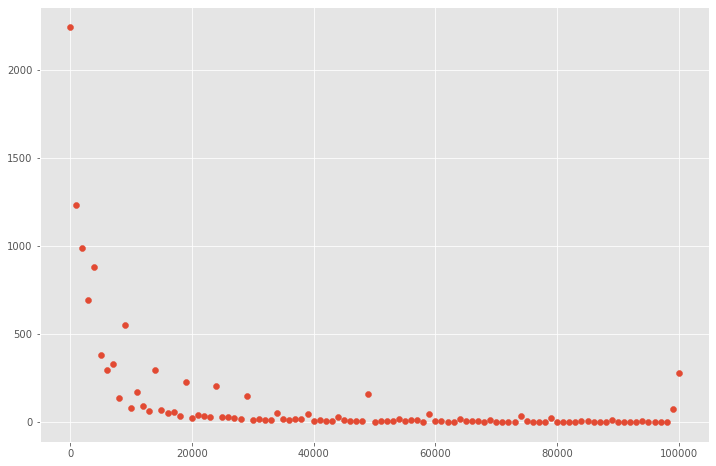

In [198]:
plt.figure(figsize=(12,8))
plt.scatter(goal_pivot.index, goal_pivot[('count', 'state')]) #(分ける要素, 高さ)
plt.show()

C:\Users\ishizuka\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


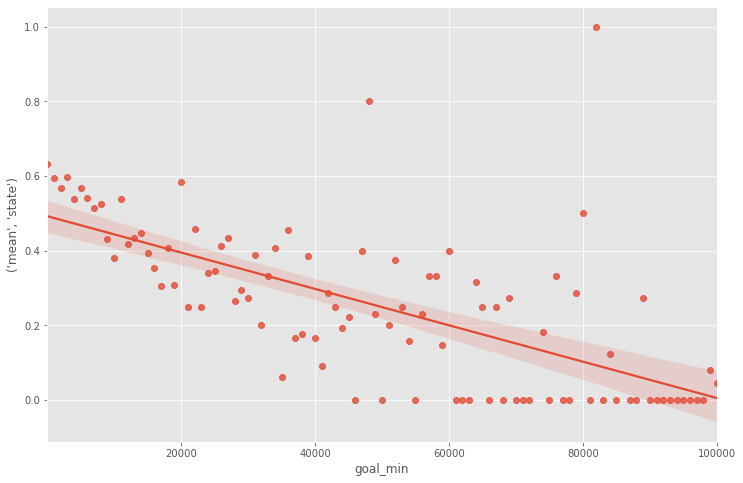

In [199]:
plt.figure(figsize=(12,8))
sns.regplot(goal_pivot.index, goal_pivot[('mean', 'state')]) #(分ける要素, 高さ)
plt.show()

## country

In [200]:
all_df["country"].value_counts()

US    14919
GB     2277
CA      959
AU      564
DE      322
FR      314
MX      287
IT      248
SE      171
NL      165
ES      161
DK      118
HK      107
NZ       87
IE       78
SG       60
NO       58
BE       54
CH       54
JP       40
AT       39
LU        7
Name: country, dtype: int64

In [201]:
country_pivot = all_df.pivot_table(index="country", values="state", aggfunc=["mean","count"])
country_pivot

,mean,count
,state,state
country,,
AT,0.357143,14
AU,0.399329,298
BE,0.250000,28
CA,0.486922,497
CH,0.419355,31
DE,0.436047,172
DK,0.588235,68
ES,0.302326,86


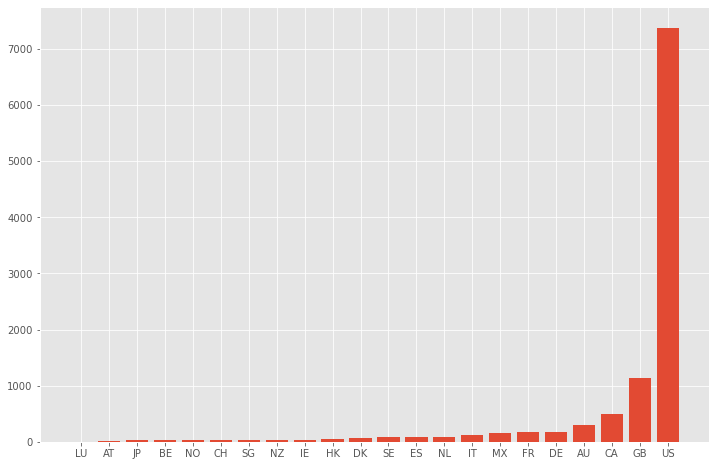

In [202]:
# count
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
plt.bar(country_pivot.sort_values(('count', 'state')).index, country_pivot.sort_values(('count', 'state'))[('count', 'state')])  
plt.show()

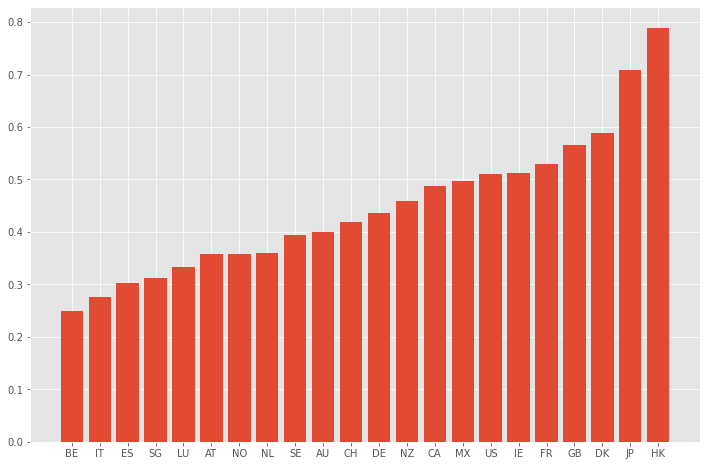

In [203]:
# state mean
plt.figure(figsize=(12, 8))
plt.bar(country_pivot.sort_values(('mean', 'state')).index, country_pivot.sort_values(('mean', 'state'))[('mean', 'state')])  
plt.show()

## duration

In [204]:
duration_pivot = all_df.pivot_table(index="duration", values="state", aggfunc=["count","mean"])
duration_pivot

,count,mean
,state,state
duration,,
1,5,0.000000
2,10,0.500000
3,6,0.500000
4,9,0.111111
5,20,0.600000
6,22,0.590909
7,73,0.630137
8,17,0.647059


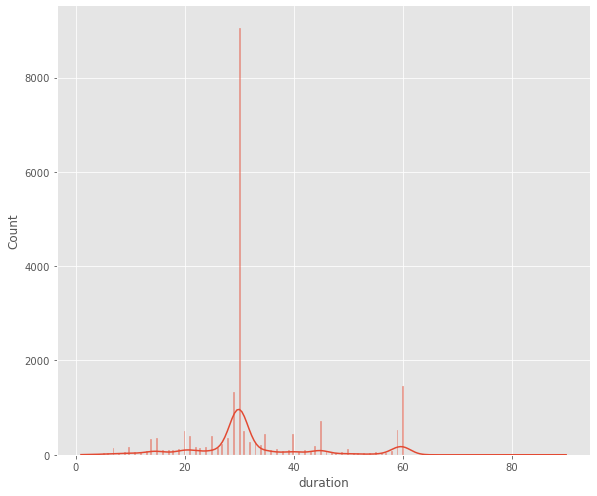

In [205]:
sns.displot(all_df['duration'], kde=True,  height=7, aspect=1.2)

C:\Users\ishizuka\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


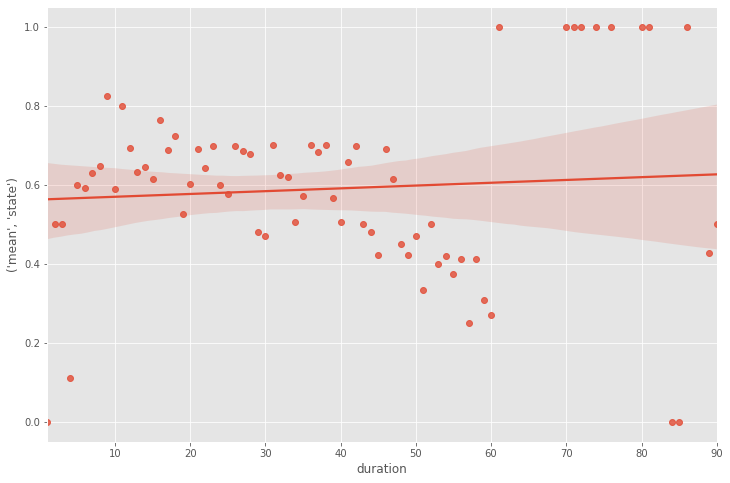

In [206]:
# 横向きはbarh
plt.figure(figsize=(12, 8))
sns.regplot(duration_pivot.index, duration_pivot[("mean","state")]) #(分ける要素, 高さ)
plt.show()

## category1

In [207]:
cate1_pivot = all_df.pivot_table(index="category1", values="state", aggfunc=["mean","count"]) 
cate1_pivot

,mean,count
,state,state
category1,,
art,0.506938,1081
comics,0.770751,253
crafts,0.352679,448
dance,0.709677,186
design,0.498270,289
fashion,0.520388,515
film & video,0.546835,1580
food,0.288515,1071


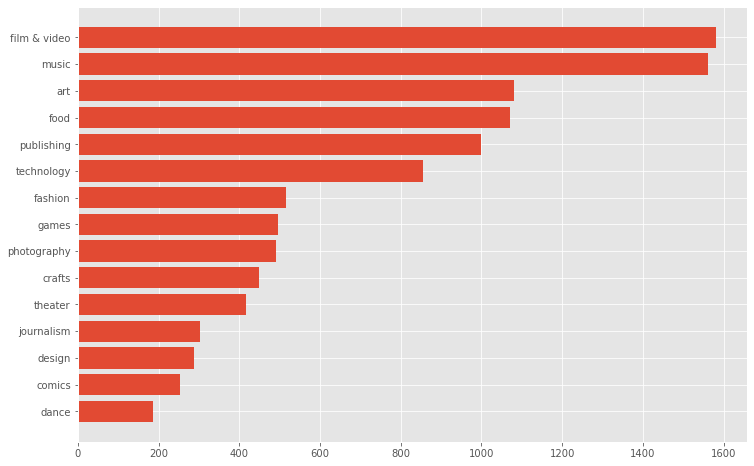

In [208]:
plt.figure(figsize=(12,8))
plt.barh(cate1_pivot.sort_values(('count', 'state')).index, cate1_pivot.sort_values(('count', 'state'))[('count', 'state')]) #(分ける要素, 高さ)
plt.show()

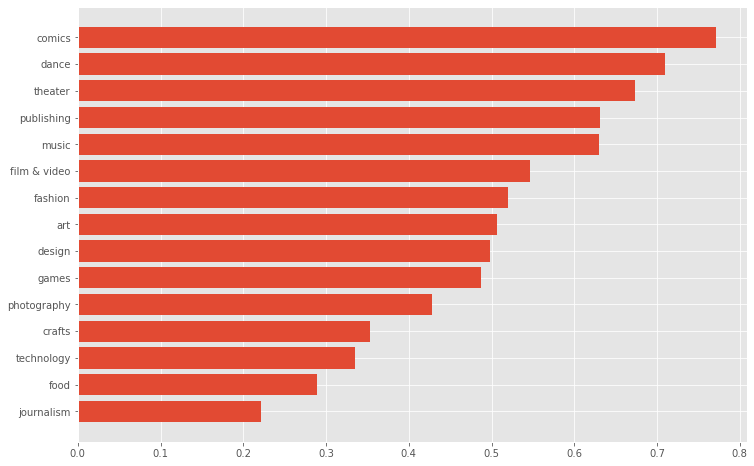

In [209]:
plt.figure(figsize=(12,8))
plt.barh(cate1_pivot.sort_values(('mean', 'state')).index, cate1_pivot.sort_values(('mean', 'state'))[('mean', 'state')]) #(分ける要素, 高さ)
plt.show()

## category2

In [210]:
print(len(all_df["category2"].unique()))

145


In [211]:
cate2_pivot = all_df.pivot_table(index=("category2"), values="state", aggfunc=["mean","count"]) 
cate2_pivot

,mean,count
,state,state
3d printing,0.239130,46
academic,0.126761,71
accessories,1.000000,80
action,0.144928,69
animals,0.250000,20
animation,0.267717,127
anthologies,0.629630,54
apparel,0.933884,121
apps,0.311688,77


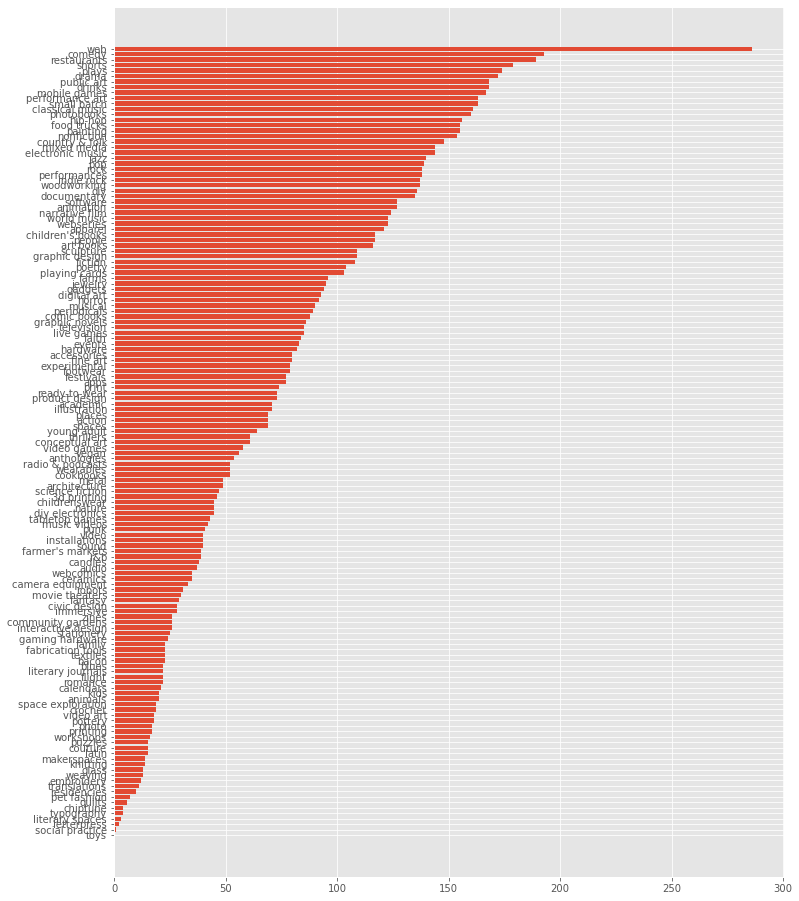

In [212]:
plt.figure(figsize=(12,16))
plt.barh(cate2_pivot.sort_values(('count', 'state')).index,
         cate2_pivot.sort_values(('count', 'state'))[('count', 'state')]) 
plt.show()

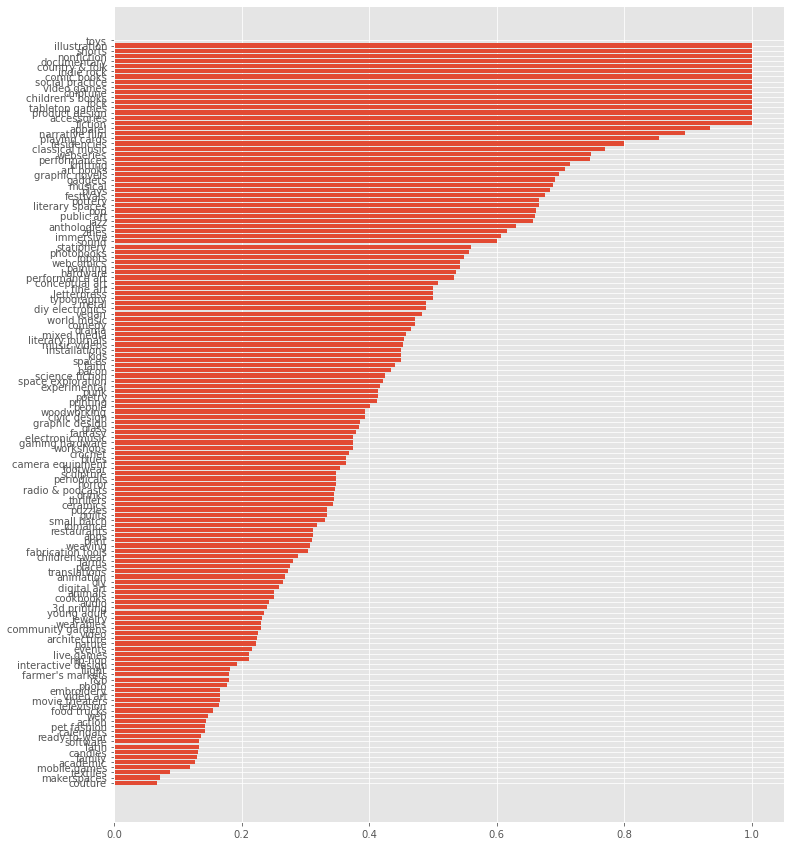

In [213]:
plt.figure(figsize=(12,15))
plt.barh(cate2_pivot.sort_values(('mean', 'state')).index,
         cate2_pivot.sort_values(('mean', 'state'))[("mean", "state")])
plt.show()

In [214]:
## category1 + category2

In [215]:
cate_pivot = all_df.pivot_table(index=("category1", "category2"), values="state", aggfunc=["mean","count"]) 
cate_pivot

mean count
                                    state state
category1    category2                         
art          ceramics            0.342857    35
             conceptual art      0.508197    61
             digital art         0.258065    93
             illustration        1.000000    71
             installations       0.450000    40
             mixed media         0.458333   144
             painting            0.541935   155
             performance art     0.533742   163
             public art          0.660714   168
             sculpture           0.348624   109
             social practice     1.000000     1
             textiles            0.086957    23
             video art           0.166667    18
comics       anthologies         0.781250    32
             comic books         1.000000    88
             events              0.250000    12
             graphic novels      0.697674    86
             webcomics           0.542857    35
crafts       candles             0.131579    38
             crochet             0.368421    19
             diy                 0.264706   136
             embroidery          0.166667    12
             glass               0.384615    13
             knitting            0.714286    14
             pottery             0.666667    18
             printing            0.411765    17
             quilts              0.333333     6
             stationery          0.560000    25
             weaving             0.307692    13
             woodworking         0.394161   137
dance        performances        0.746377   138
             residencies         0.800000    10
             spaces              0.681818    22
             workshops           0.375000    16
design       architecture        0.224490    49
             civic design        0.392857    28
             graphic design      0.385321   109
             interactive design  0.192308    26
             product design      1.000000    73
             toys                     NaN     0
             typography          0.500000     4
fashion      accessories         1.000000    80
             apparel             0.933884   121
             childrenswear       0.288889    45
             couture             0.066667    15
             footwear            0.354430    79
             jewelry             0.231579    95
             pet fashion         0.142857     7
             ready-to-wear       0.136986    73
film & video action              0.144928    69
             animation           0.267717   127
             comedy              0.435897   156
             documentary         1.000000   135
             drama               0.465116   172
             experimental        0.340909    44
             family              0.130435    23
             fantasy             0.379310    29
             festivals           0.400000    20
             horror              0.347826    92
             movie theaters      0.166667    30
             music videos        0.452381    42
             narrative film      0.895161   124
             romance             0.318182    22
             science fiction     0.425532    47
             shorts              1.000000   179
             television          0.164706    85
             thrillers           0.344262    61
             webseries           0.747967   123
food         bacon               0.434783    23
             community gardens   0.230769    26
             cookbooks           0.250000    52
             drinks              0.345238   168
             events              0.211268    71
             farmer's markets    0.179487    39
             farms               0.281250    96
             food trucks         0.154839   155
             restaurants         0.312169   189
             small batch         0.331288   163
             spaces              0.272727    33
             vegan               0.482143    56
games        gaming hardware     0.375000    24
     

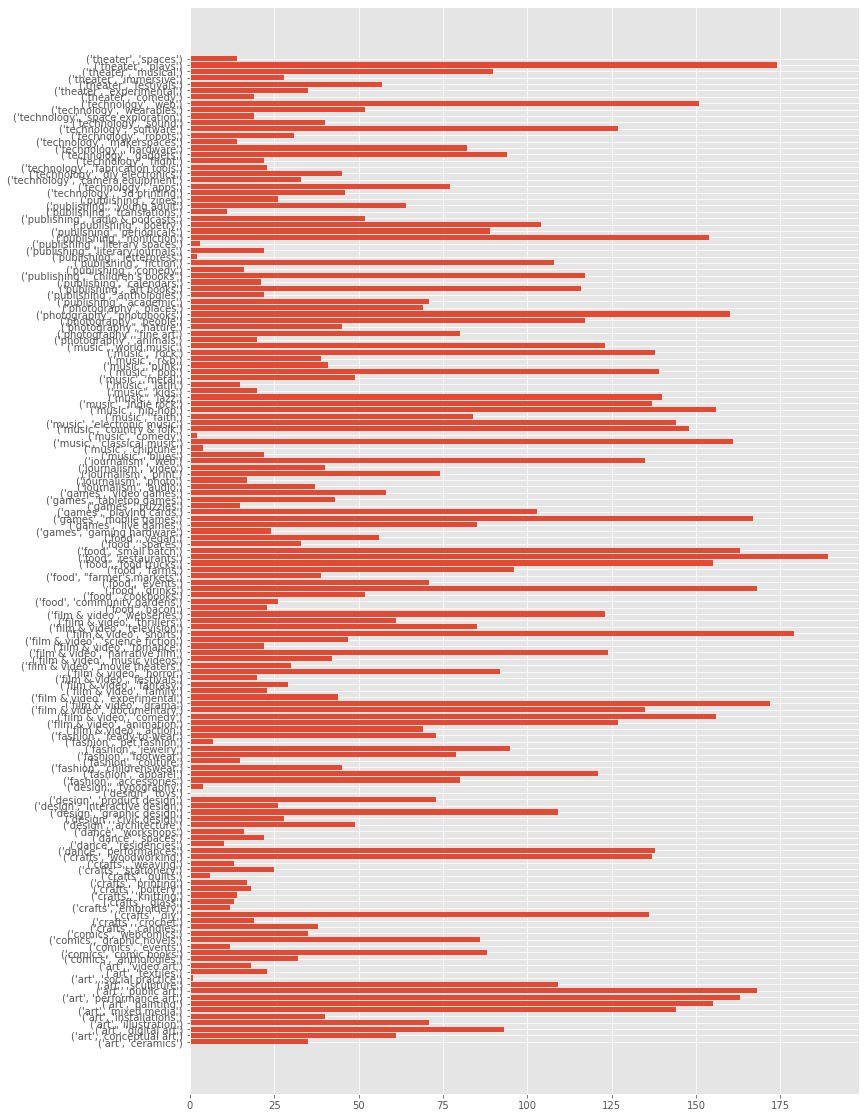

In [216]:
plt.figure(figsize=(12,20))
plt.barh([str(cate) for cate in cate_pivot.index],
         cate_pivot[('count', 'state')])
plt.show()

## html_content

In [217]:
print(all_df["html_content"].iloc[0])

<div class="contents"><div><span class="bold">Mark Saggia</span> is an Italian writer who emigrated in Switzerland.<p>He is a Nerd, Star Wars, Marvel Comics and videogames Fanatic! IT's part of his entire life.</p><p>The story born when Mark, thinking about The Big Bang Theory, understood that what's missing in the world is a nerd story for who loves videogames and all "things" like this. A story wrote in typical nerd language.</p><p>The book has been published in Italian. It can be found at amazon.it or via Facebook. You can find some info at <a href="http://dummy.com" to a large one, who wouldn't have respect for his ideas. </p><p>They can do many things, sometimes only for money, that's not our idea of success. </p><p>This means that our small, unique, caring publisher, can’t reach the USA. No matter how hard they tries.</p><p>Money for printing, find someone for distribution, marketing and other things are needed. </p><p>So we ventured to USA. We searched and searched….and finally 

In [218]:
for i in range(all_df["html_content"][all_df["country"]=="JP"].shape[0]):
    print(all_df["html_content"][all_df["country"]=="JP"].iloc[i])
    print()

<div class="contents"><div><div class="template asset" contenteditable="false" data-alt-text="Photo by KURO" data-caption="Photo by KURO" data-id="_xxx_">
<figure>
<img alt="Photo by KURO" class="fit lazyload" data-src="http://dummy.com"/>
<figcaption class="px2">Photo by KURO</figcaption>
</figure>
</div>
<br/>
<p>日本及びアジアの人気コスプレイヤーを２０名以上集めた写真集です。 コスプレイヤーに絶大な支持を得ているカメラマンKUROによる撮影の写真集です。アジアの人気コスプレイヤーが日本の観光名所等で撮影する貴重な世界初のデジタル作品集およびハードカバー写真集。今後シリーズ化し、ヨーロッパのコスプレイヤー編なども出版します。</p>
<p>写真は、日本各地の観光名所などと連携し、オリジナルの擬人化キャラクターをデザイン。完全オリジナルのアニメキャラクターと共にコスプレイヤーを世界に発信致します。</p>
<p>公式サイトはこちら</p>
<p> <a href="http://dummy.com">公式サイト　/ Official Site</a> </p>
<p>This collection of photos brings together 20 of the most popular cosplayers from Japan and Asia. The photos in this collection were taken by KURO, a photographer who has won a huge following among cosplayers. The world’s first digital collection&amp; hardcover version photo book, this valuable work features popular Asian cosplayers at famous tourist

# 特徴量エンジニアリング

## 順序特徴量のマッピング

## binning

C:\Users\ishizuka\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


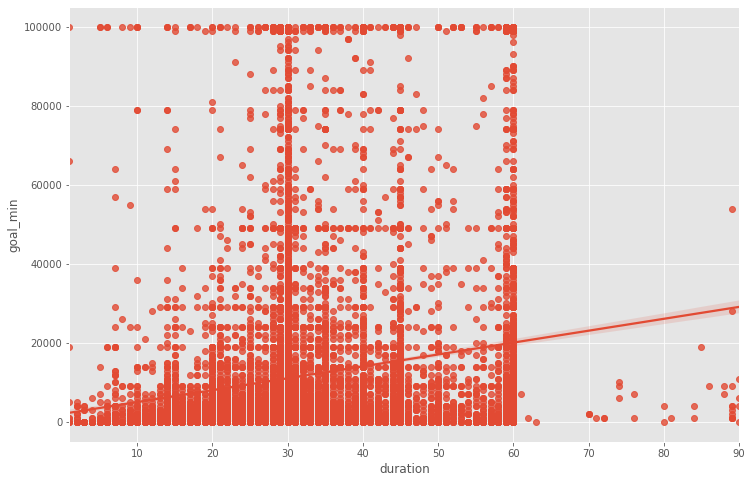

In [220]:
plt.figure(figsize=(12, 8))
sns.regplot(all_df["duration"], all_df["goal_min"])
plt.show()

In [221]:
# goal
bin_edges = [-1, 19999, 39999, 79999, np.inf]
all_df["bins_goal"] = pd.cut(all_df["goal_min"], bins=bin_edges, labels=False)

# duration
bin_edges = [-1, 20, 45, 60, 100]
all_df["bins_duration"] = pd.cut(all_df["duration"], bins=bin_edges, labels=False)

In [222]:
# ビンの可視化

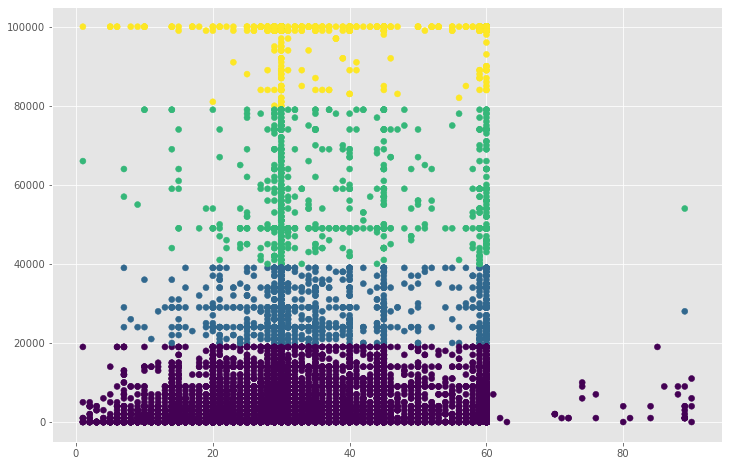

In [223]:
plt.figure(figsize=(12, 8))
plt.scatter(all_df["duration"], all_df["goal_min"], c=all_df["bins_goal"])
plt.show()

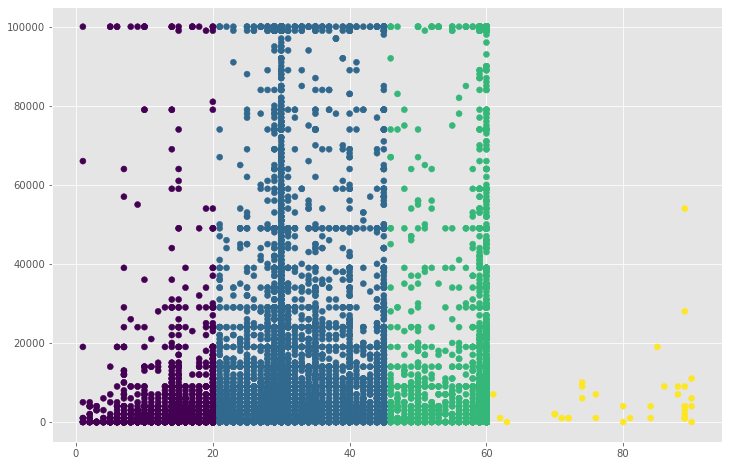

In [224]:
plt.figure(figsize=(12, 8))
plt.scatter(all_df["duration"], all_df["goal_min"], c=all_df["bins_duration"])
plt.show()

## 変数の組み合わせ

In [225]:
all_df.dtypes

id                   int64
goal                object
country             object
duration             int64
category1           object
category2           object
html_content        object
state              float64
goal_upper_flag       bool
goal_lower_flag       bool
goal_min             int32
bins_goal            int64
bins_duration        int64
dtype: object

### カテゴリ変数×カテゴリ変数

In [226]:
# cagtegory1+category2
all_df["category"] = all_df["category1"] + "_" + all_df["category2"]

# country+category
all_df["country+category1"] = all_df["country"] + all_df["category1"]
all_df["country+category2"] = all_df["country"] + all_df["category2"]
all_df["country+category"] = all_df["country"] + all_df["category"]

# bin+bin
all_df["bins_goalduration"] = all_df["bins_duration"] + all_df["bins_goal"]

### 数値変数×数値変数

In [227]:
# goal / duration
all_df["goalMin/duration"] = all_df["goal_min"] / (all_df["duration"] + 1)

# goal * duration
all_df["goalMin*duration"] = all_df["goal_min"] * (all_df["duration"])

C:\Users\ishizuka\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-0.1, 1.1)

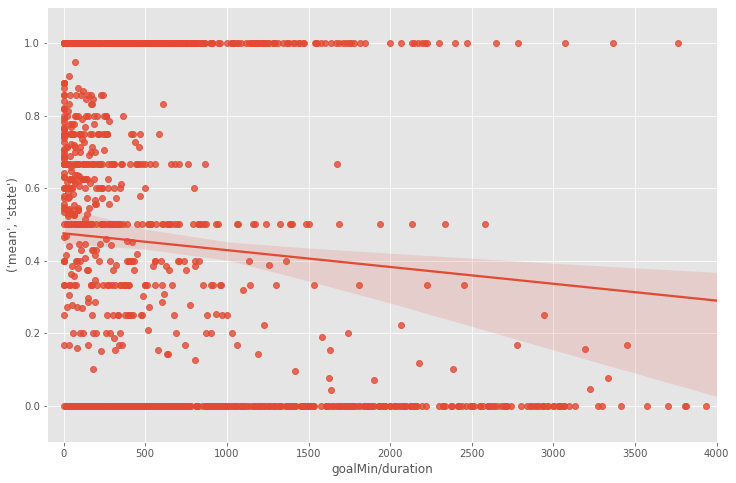

In [228]:
# 可視化
gd_pivot = all_df.pivot_table(index=("goalMin/duration"), values="state", aggfunc=["mean"]) 

plt.figure(figsize=(12, 8))
sns.regplot(gd_pivot.index, gd_pivot[("mean", "state")])
plt.xlim(-100, 4000)
plt.ylim(-0.1, 1.1)

In [45]:
# clipping

### カテゴリ変数×数値変数

#### 集約特徴量

In [229]:
cate_cols = [
    "category1",
    "category2",
    "category",
    "country",
#     "country+category1",
#     "country+category2",
#     "country+category",
#     "bins_duration",
#     "bins_goal",
    "bins_goalduration",
]

group_values = [
    "goal_min",
    "duration",
    "goalMin/duration",
    "goalMin*duration"
]

for col in cate_cols:
    for group in group_values:
        all_df["mean_{}_{}".format(col, group)] = all_df[col].map(all_df.groupby(col).mean()[group]) # 平均
        all_df["std_{}_{}".format(col, group)] = all_df[col].map(all_df.groupby(col).std()[group])   # 分散
        all_df["max_{}_{}".format(col, group)] = all_df[col].map(all_df.groupby(col).max()[group])   # 最大値
        all_df["min_{}_{}".format(col, group)] = all_df[col].map(all_df.groupby(col).min()[group])   # 最小値
        all_df["nunique_{}_{}".format(col, group)] = all_df[col].map(all_df.groupby(col).nunique()[group])   # uniaue
        all_df["median_{}_{}".format(col, group)] = all_df[col].map(all_df.groupby(col).median()[group])   # 中央値


#### 相対値

In [230]:
cate_cols = [
#     "category1",
#     "category2",
    "category",
    "country",
#     "country+category1",
#     "country+category2",
#     "country+category",
#     "bins_duration",
#     "bins_goal",
#     "bins_goalduration",
]

group_values = [
    "goal_min",
    "duration",
    "goalMin/duration",
    "goalMin*duration"
]

# カテゴリごとの平均との差
for col in cate_cols:
    for group in group_values:
        all_df["{}_diff_{}".format(col, group)] = all_df[group] - all_df["mean_{}_{}".format(col, group)]

## Frecency Encoding

In [231]:
cat_cols = [
        "category1",
        "category2",
        "category",
        "country",
        "country+category1",
        "country+category2",
        "country+category",
        "bins_duration",
        "bins_goal",
        "bins_goalduration",
    ]

for col in cat_cols:
    freq = all_df[col].value_counts()
    # カテゴリの出現回数で置換
    all_df["freq_{}".format(col)] = all_df[col].map(freq)

In [232]:
all_df.shape

(21089, 158)

## NLP

### 前処理

In [50]:
import texthero as hero
from texthero import preprocessing

In [51]:
custom_pipeline_only_tags = [
    preprocessing.fillna,
    preprocessing.remove_html_tags,
    preprocessing.lowercase,
    preprocessing.remove_digits,
    preprocessing.remove_stopwords,
    preprocessing.remove_whitespace,
    preprocessing.stem
]

custom_pipeline_all = [
    preprocessing.fillna,
    preprocessing.remove_html_tags,
    preprocessing.lowercase,
    preprocessing.remove_digits,
    preprocessing.remove_punctuation,
    preprocessing.remove_diacritics,
    preprocessing.lowercase,
    preprocessing.remove_stopwords,
    preprocessing.remove_whitespace,
    preprocessing.stem
]

In [52]:
text_df = pd.DataFrame()
text_df["html_content"] = all_df["html_content"]
text_df["clean_html_content_only_tags"] = hero.clean(all_df["html_content"], custom_pipeline_only_tags)
text_df["clean_html_content"] = hero.clean(all_df["html_content"], custom_pipeline_all)

In [165]:
print(text_df["html_content"][757])

<div class="contents"><div><div class="template asset" contenteditable="false" data-alt-text="Photo by KURO" data-caption="Photo by KURO" data-id="_xxx_">
<figure>
<img alt="Photo by KURO" class="fit lazyload" data-src="http://dummy.com"/>
<figcaption class="px2">Photo by KURO</figcaption>
</figure>
</div>
<br/>
<p>日本及びアジアの人気コスプレイヤーを２０名以上集めた写真集です。 コスプレイヤーに絶大な支持を得ているカメラマンKUROによる撮影の写真集です。アジアの人気コスプレイヤーが日本の観光名所等で撮影する貴重な世界初のデジタル作品集およびハードカバー写真集。今後シリーズ化し、ヨーロッパのコスプレイヤー編なども出版します。</p>
<p>写真は、日本各地の観光名所などと連携し、オリジナルの擬人化キャラクターをデザイン。完全オリジナルのアニメキャラクターと共にコスプレイヤーを世界に発信致します。</p>
<p>公式サイトはこちら</p>
<p> <a href="http://dummy.com">公式サイト　/ Official Site</a> </p>
<p>This collection of photos brings together 20 of the most popular cosplayers from Japan and Asia. The photos in this collection were taken by KURO, a photographer who has won a huge following among cosplayers. The world’s first digital collection&amp; hardcover version photo book, this valuable work features popular Asian cosplayers at famous tourist

In [166]:
text_df["clean_html_content_only_tags"][757]

photo kuro 日本及びアジアの人気コスプレイヤーを２０名以上集めた写真集です コスプレイヤーに絶大な支持を得ているカメラマンkuroによる撮影の写真集ですアジアの人気コスプレイヤーが日本の観光名所等で撮影する貴重な世界初のデジタル作品集およびハードカバー写真集今後シリーズ化しヨーロッパのコスプレイヤー編なども出版します 写真は日本各地の観光名所などと連携しオリジナルの擬人化キャラクターをデザイン完全オリジナルのアニメキャラクターと共にコスプレイヤーを世界に発信致します 公式サイトはこちら 公式サイト / offici site collect photo bring togeth popular cosplay japan asia. photo collect taken kuro, photograph huge follow among cosplayers. world first digit collect hardcov version photo book, valuabl work featur popular asian cosplay famous tourist attract elsewher japan. plan produc seri includ european version, among others. kuro kuro 写真家 kuro のプロフィール 1983年生まれ 福岡在住 彼はアニメの世界に精通しておりその世界観をコスプレイヤーの写真で表現しますkuroの作品の特徴は本物の水や火を使うことでグラフィックでは表現できないリアルな作品を作り上げることです また日本の美しい風景にコスプレイヤー達をマッチさせることが上手くコスプレイヤーに多くの支持を得ている写真家です 福岡県鞍手町の廃校を利用したコスプレイヤーの聖地であるくらて学園の専属カメラマンもつとめている photograph profile: kuro born . current resid fukuoka. kuro well-vers world anime, express worldview via photograph cosplayers. use real water, fire, etc. distinct characterist wor

In [54]:
text_df["clean_html_content"][757]

'photo kuro ri ben ji biazianoren qi kosupureiyawo20m yi shang ji metaxi zhen ji desu. kosupureiyaniju da nazhi chi wode teirukameramankuroniyorucuo ying noxi zhen ji desu. azianoren qi kosupureiyagari ben noguan guang ming suo deng decuo ying surugui zhong nashi jie chu nodezitaruzuo pin ji oyobihadokabaxi zhen ji . jin hou shirizuhua shi, yorotsupanokosupureiyabian nadomochu ban shimasu. xie zhen ha, ri ben ge di noguan guang ming suo nadotolian xi shi, orizinarunoni ren hua kiyarakutawodezain. wan quan orizinarunoanimekiyarakutatogong nikosupureiyawoshi jie nifa xin zhi shimasu. gong shi saitohakochira gong shi saito offici site collect photo bring togeth popular cosplay japan asia photo collect taken kuro photograph huge follow among cosplay world first digit collect hardcov version photo book valuabl work featur popular asian cosplay famous tourist attract elsewher japan plan produc seri includ european version among other kuro kuro xie zhen jia kuro nopurohuiru 1983nian sheng mar

### basic features

In [55]:
# basic reatures
def get_basic_features(dataframe, column):
    all_df[column + '_num_chars'] = dataframe[column].apply(len)
    all_df[column + '_num_exclamation_marks'] = dataframe[column].apply(lambda x: x.count('!'))
    all_df[column + '_num_question_marks'] = dataframe[column].apply(lambda x: x.count('?'))
    all_df[column + '_num_punctuation'] = dataframe[column].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    all_df[column + '_num_symbols'] = dataframe[column].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    all_df[column + '_num_words'] = dataframe[column].apply(lambda x: len(x.split()))
    all_df[column + '_num_unique_words'] = dataframe[column].apply(lambda x: len(set(w for w in x.split())))
    all_df[column + '_words_vs_unique'] = all_df[column + '_num_unique_words'] / (all_df[column + '_num_words']+1)
    all_df[column + '_words_vs_chars'] = all_df[column  + '_num_words'] / (all_df[column + '_num_chars']+1)

# html_contentに対して
get_basic_features(text_df, "html_content")
# clean_html_content_only_tagsに対して
get_basic_features(text_df, "clean_html_content_only_tags")

In [56]:
# clean_html_contentに対して
all_df["len_clean_html_content"] = text_df["clean_html_content"].apply(len)
# 0かどうか
all_df["frag_len0"] = all_df["len_clean_html_content"]==0

In [57]:
all_df.shape

(21089, 306)

### タグを集計

In [167]:
import re

In [189]:
# 各タグの数を集計
tags = ["<figure", "<video", "bold"]

for tag in tags:
    all_df["tag_num_"+tag] = text_df["html_content"].apply(lambda x: len(re.findall(tag, x)))
    
# 足、割
all_df["tag_num_figurevideo"] = all_df["tag_num_<figure"] + all_df["tag_num_<video"]
all_df["tag_num_figurevideo/num_chars"] = all_df["tag_num_figurevideo"] / all_df["html_content_num_chars"]

### tf-idf, UMAP

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

In [59]:
from scipy.sparse.csgraph import connected_components
import os
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'

import umap

In [60]:
%%time
# tf-idf + UMAP
pipe_raw = make_pipeline(TfidfVectorizer(norm="l2", max_df=0.1, min_df=2),
                         umap.UMAP(n_components=30),
                        )
pipe_remove_tags = make_pipeline(TfidfVectorizer(norm="l2", max_df=0.1, min_df=2),
                                 umap.UMAP(n_components=20),
                                )
pipe_only_text = make_pipeline(TfidfVectorizer(norm="l2", max_df=0.1, min_df=2),
                               umap.UMAP(n_components=20),
                              )

raw_um = pipe_raw.fit_transform(text_df["html_content"])
remove_tags_um = pipe_remove_tags.fit_transform(text_df["clean_html_content_only_tags"])
only_text_um = pipe_only_text.fit_transform(text_df["clean_html_content"])

Wall time: 5min 53s


In [61]:
# 特徴量に追加
names = ["raw", "remove_tags", "only_text"]
for i, X_um in enumerate([raw_um, remove_tags_um, only_text_um]):
    for n in range(X_um.shape[1]):
        all_df["umap_{}_{}".format(names[i],n)] = X_um[:, n]

In [62]:
all_df.shape

(21089, 562)

In [63]:
# tf-idfが高いまたは低い特徴量を表示する
# パイプラインから取り出す
tf = pipe_only_text.named_steps["tfidfvectorizer"]
X_tfid = tf.transform(text_df["clean_html_content"])
# tf-idfを取得
max_value = X_tfid.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# feature names# を取得
feature_names = np.array(tf.get_feature_names())

print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:50]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-50:]]))

Features with lowest tfidf:
['nomme' 'homologu' 'prolonge' '80gr' 'intervienn' 'testent' 'thermiqu'
 'chaleureus' 'tissag' 'approximatif' 'amov' 'bouclier' 'etir' 'arromba'
 'taillant' 'noue' 'embarqu' 'environnement' 'inferieur' 'adhesif'
 'sommet' '2015nian' 'geografica' 'soldati' 'simili' 'dhanuka' 'smau'
 'gurgaon' 'teachniqu' 'capabilit' 'haryana' 'silicio' 'zouk'
 'postprodukt' 'verhandlungen' 'piratag' 'ouest' 'risultato' 'filier'
 'nahmen' 'rimangono' 'calda' 'entrano' 'discut' 'subi' 'californi'
 'rollerballth' 'keychainthi' 'pensmal' 'briller']
Features with highest tfidf: 
['rodney' 'photographi' 'adc' 'carolin' 'prototyp' 'einband' 'none'
 'doomsday' 'logo' 'bandcamp' 'hear' 'vinyl' 'cash' 'www' 'format' 'total'
 'leagu' 'bend' 'appreci' 'interess' 'sure' 'gratitud' 'exampl' 'poster'
 'bruh' 'p1' 'concept' 'today' 'draw' 'shirt' 'fail' 'generat' 'paul'
 'stick' 'http' 'ship' 'outlin' 'photo' 'paint' 'cancel' 'detail' 'click'
 'worker' 'sunday' 'noth' 'vote' 'facebook' 'prom

In [64]:
# %%time
# # 特徴量選択
# selecter = SelectPercentile(percentile=15, score_func=mutual_info_classif)
# selecter.fit(X_tfid[:len(train_df)], train_df["state"])
# X_tfid_select = selecter.transform(X_tfid)

# print(X_tfid.shape)
# print(X_tfid_select.shape)

In [65]:
# 単語ベクトルを特徴量として追加
#feature_names = np.array(tf_vect.get_feature_names())
# vect_df = pd.DataFrame(X_tfid_select.toarray()) #, columns=feature_names)
# all_df = pd.concat([all_df, vect_df], axis=1)
# all_df.shape

### LDA

In [66]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

pipe_lda = make_pipeline(CountVectorizer(max_df=0.1,
                                         min_df=2,
                                         #max_features=5000
                                        ),
                         LatentDirichletAllocation(n_components=40,
                                                   random_state=123,
                                                   learning_method="batch",
                                                   max_iter=20)
                        )
x_lda = pipe_lda.fit_transform(text_df["clean_html_content"])

Wall time: 8min 14s


In [67]:
# 各トピックを表す言葉を表示する
n_top_words = 10
vect = pipe_lda.named_steps['countvectorizer']
lda = pipe_lda.named_steps['latentdirichletallocation']
feature_names = vect.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
game card player height soundcloud charact emb ifram max fun
Topic 2:
coffe restaur truck kitchen shop bar serv drink cafe brew
Topic 3:
comic charact seri anim novel issu fan hero horror adventur
Topic 4:
di il la che un per una del le con
Topic 5:
recip cook flavor sauc chees chicken hot bbq tast pepper
Topic 6:
size shoe fit cloth fabric wear fashion comfort leather shirt
Topic 7:
candl tm og bee er til en pa wax af
Topic 8:
farm water organ plant natur tea fruit healthi farmer sustain
Topic 9:
dog pet anim shelter wave rescu tom surf hat treat
Topic 10:
adam hors orlean queer dinosaur documentari princess jake lgbtq author
Topic 11:
de et la le les en un des pour est
Topic 12:
app user devic technolog connect phone softwar data system comput
Topic 13:
ice robot scienc speci cream fire wildlif anim butterfli mar
Topic 14:
media site facebook onlin fee sell check social expens week
Topic 15:
album song band musician cd master mix track tour guitar
Topic 16:
say got away thou

In [68]:
# 特徴量に追加
all_df = pd.concat([all_df,
                    pd.DataFrame(x_lda, columns=["lda_{}".format(i) for i in range(1, x_lda.shape[1]+1)])],
                   axis=1)
all_df["lda"] = x_lda.argmax(axis=1)
all_df["lda"].value_counts()

14    1810
13    1524
15    1467
29    1418
30    1198
19    1151
39    1147
2      950
1      835
11     812
7      789
5      783
0      780
26     759
17     706
27     625
22     589
20     459
21     443
38     398
4      299
10     291
24     265
31     242
34     235
18     164
33     146
25     137
23      89
35      83
12      71
6       68
9       60
3       55
8       53
36      52
28      50
32      47
16      30
37       9
Name: lda, dtype: int64

In [69]:
# トピック数の決定

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import lightgbm as lgb

def topic_score(n_components=10, model=lgb.LGBMClassifier()):
    # lda
    pipe_lda = make_pipeline(CountVectorizer(max_df=0.1,
                                             min_df=2,
                                             #max_features=5000
                                            ),
                             LatentDirichletAllocation(n_components=n_components,
                                                       random_state=123,
                                                       learning_method="batch",
                                                       max_iter=20
                                                      )
                            )
    X_lda = pipe_lda.fit_transform(text_df["clean_html_content"])
    X_lda = X_lda[:train_df.shape[0]]
    
    # 主要特徴量も追加
    df = all_df.loc[:train_df.shape[0]-1, ['goal_min', 'country', 'duration',  'category']]
    
    from sklearn.preprocessing import LabelEncoder
    lb = LabelEncoder()
    for col in df.columns[df.dtypes=="object"]:
        df[col] = lb.fit_transform(df[col])
        
    X = np.concatenate([df, X_lda], axis=1)
    y = train_df["state"]
    
    # 交差検証                              
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring="f1")
    
    return scores

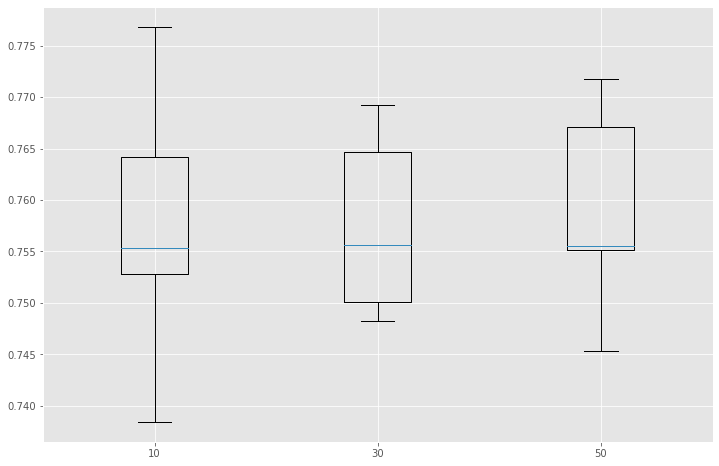

Wall time: 21min 29s


In [70]:
%%time
scores_df = pd.DataFrame()
components = [30, 40, 50]

for i in components:
    scores = topic_score(n_components=i)
    scores_df[i] = scores
    
plt.figure(figsize=(12, 8))
plt.boxplot(scores_df, labels=scores_df.columns) 
plt.show()

## スケーリング

## エンコーディング

In [71]:
list(all_df.columns[(all_df.dtypes=="object") | (all_df.dtypes=="bool")])

['goal',
 'country',
 'category1',
 'category2',
 'html_content',
 'goal_upper_flag',
 'goal_lower_flag',
 'category',
 'country+category1',
 'country+category2',
 'country+category',
 'frag_len0']

In [72]:
all_df_enc = all_df.copy()
all_df_enc = all_df_enc.drop(columns=["id", "goal", "html_content"])

### Label Eccoding

In [73]:
# ラベルエンコーディングするカラム
cat_cols = ['goal_upper_flag', 'goal_lower_flag', 'country+category1', 'country+category2', 'country+category','frag_len0']

In [74]:
# Label Eccoding
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
for col in cat_cols:
    all_df_enc[col] = lb.fit_transform(all_df_enc[col])

### Target Encoding

In [75]:
from sklearn.model_selection import KFold

# データ分割
train = all_df_enc[all_df_enc["state"].notnull()]
test_x = all_df_enc[all_df_enc["state"].isnull()].drop(columns=["state"])
train_x = train.drop(columns=["state"])
train_y = train["state"]

# Target Encodingするカラム
cat_cols = list(all_df_enc.columns[(all_df_enc.dtypes=="object")])
cat_cols

['country', 'category1', 'category2', 'category']

In [76]:
# Target Encoding

# クロスバリデーション用に学習データと検証データのセットを５つ作る
# クロスバリデーションのfoldごとにtarget encodingをやり直す
tr_x_dict = {}
va_x_dict = {}
tr_y_dict = {}
va_y_dict = {}

kf = KFold(n_splits=5, shuffle=True, random_state=124)
for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):

    # 学習データとバリデーションデータに分割
    tr_x, va_x = train_x.iloc[tr_idx].copy(), train_x.iloc[va_idx].copy()
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    for c in cat_cols:
        # バリデーションデータを変換
        data_tmp = pd.DataFrame({c: tr_x[c], 'target': tr_y})
        target_mean = data_tmp.groupby(c)['target'].mean()
        va_x.loc[:, c] = va_x[c].map(target_mean)
        va_x = va_x.fillna(data_tmp["target"].mean()) # nanになってしまったところは平均値で埋める

        # 学習データを変換
        tmp = np.repeat(np.nan, tr_x.shape[0])
        kf_encoding = KFold(n_splits=5, shuffle=True, random_state=23)
        for idx_1, idx_2 in kf_encoding.split(tr_x):
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)
        tr_x.loc[:, c] = tmp
        tr_x = tr_x.fillna(data_tmp["target"].mean()) # nanになってしまったところは平均値で埋める

    # 学習データと検証データを保存
    tr_x_dict["fold_{}".format(i)] = tr_x
    va_x_dict["fold_{}".format(i)] = va_x
    tr_y_dict["fold_{}".format(i)] = tr_y
    va_y_dict["fold_{}".format(i)] = va_y

In [77]:
# テストデータと学習データ全体を変換する
for c in cat_cols:
    # テストデータを変換
    data_tmp = pd.DataFrame({c: train_x[c], 'target': train_y})
    target_mean = data_tmp.groupby(c)['target'].mean()
    test_x[c] = test_x[c].map(target_mean)
    test_x = test_x.fillna(data_tmp["target"].mean()) # nanになってしまったところは平均値で埋める

    # 学習データ全体を変換
    tmp = np.repeat(np.nan, train_x.shape[0])
    kf = KFold(n_splits=5, shuffle=True, random_state=72)
    for idx_1, idx_2 in kf.split(train_x):
        target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
        tmp[idx_2] = train_x[c].iloc[idx_2].map(target_mean)
    train_x[c] = tmp
    train_x = train_x.fillna(data_tmp["target"].mean()) # nanになってしまったところは平均値で埋める


print(train_x.shape)
print(test_x.shape)

(10545, 599)
(10544, 599)


# モデル構築

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

## データ分割

In [79]:
# # Label encoding or One-Hot encoding の場合
# all_df_last = all_df_label

# # 不要な特徴量の削除
# all_df_last = all_df_last.drop(columns=["id", "goal", "html_content"])

# # データ分割
# train = all_df_last[all_df_last["state"].notnull()]
# test = all_df_last[all_df_last["state"].isnull()].drop(columns=["state"])

# X = train.drop(columns=["state"])
# y = train["state"]

In [80]:
# target encoding の場合
X = train_x
y = train_y
test = test_x

In [81]:
X.head()

,country,duration,category1,category2,goal_upper_flag,goal_lower_flag,goal_max,goal_min,goal_mean,goal_q25,goal_q75,bins_goal,bins_duration,category,country+category1,country+category2,country+category,bins_goalduration,goalMax/duration,goalMin/duration,goalMean/duration,goalMax*duration,goalMin*duration,goalMean*duration,mean_category1_goal_min,std_category1_goal_min,max_category1_goal_min,min_category1_goal_min,nunique_category1_goal_min,median_category1_goal_min,mean_category1_goal_max,std_category1_goal_max,max_category1_goal_max,min_category1_goal_max,nunique_category1_goal_max,median_category1_goal_max,mean_category1_goal_mean,std_category1_goal_mean,max_category1_goal_mean,min_category1_goal_mean,nunique_category1_goal_mean,median_category1_goal_mean,mean_category1_duration,std_category1_duration,max_category1_duration,min_category1_duration,nunique_category1_duration,median_category1_duration,mean_category1_goalMax/duration,std_category1_goalMax/duration,max_category1_goalMax/duration,min_category1_goalMax/duration,nunique_category1_goalMax/duration,median_category1_goalMax/duration,mean_category1_goalMin/duration,std_category1_goalMin/duration,max_category1_goalMin/duration,min_category1_goalMin/duration,nunique_category1_goalMin/duration,median_category1_goalMin/duration,mean_category1_goalMax*duration,std_category1_goalMax*duration,max_category1_goalMax*duration,min_category1_goalMax*duration,nunique_category1_goalMax*duration,median_category1_goalMax*duration,mean_category1_goalMin*duration,std_category1_goalMin*duration,max_category1_goalMin*duration,min_category1_goalMin*duration,nunique_category1_goalMin*duration,median_category1_goalMin*duration,mean_category2_goal_min,std_category2_goal_min,max_category2_goal_min,min_category2_goal_min,nunique_category2_goal_min,median_category2_goal_min,mean_category2_goal_max,std_category2_goal_max,max_category2_goal_max,min_category2_goal_max,nunique_category2_goal_max,median_category2_goal_max,mean_category2_goal_mean,std_category2_goal_mean,max_category2_goal_mean,min_category2_goal_mean,nunique_category2_goal_mean,median_category2_goal_mean,mean_category2_duration,std_category2_duration,max_category2_duration,min_category2_duration,nunique_category2_duration,median_category2_duration,mean_category2_goalMax/duration,std_category2_goalMax/duration,max_category2_goalMax/duration,min_category2_goalMax/duration,nunique_category2_goalMax/duration,median_category2_goalMax/duration,mean_category2_goalMin/duration,std_category2_goalMin/duration,max_category2_goalMin/duration,min_category2_goalMin/duration,nunique_category2_goalMin/duration,median_category2_goalMin/duration,mean_category2_goalMax*duration,std_category2_goalMax*duration,max_category2_goalMax*duration,min_category2_goalMax*duration,nunique_category2_goalMax*duration,median_category2_goalMax*duration,mean_category2_goalMin*duration,std_category2_goalMin*duration,max_category2_goalMin*duration,min_category2_goalMin*duration,nunique_category2_goalMin*duration,median_category2_goalMin*duration,mean_category_goal_min,std_category_goal_min,max_category_goal_min,min_category_goal_min,nunique_category_goal_min,median_category_goal_min,mean_category_goal_max,std_category_goal_max,max_category_goal_max,min_category_goal_max,nunique_category_goal_max,median_category_goal_max,mean_category_goal_mean,std_category_goal_mean,max_category_goal_mean,min_category_goal_mean,nunique_category_goal_mean,median_category_goal_mean,mean_category_duration,std_category_duration,max_category_duration,min_category_duration,nunique_category_duration,median_category_duration,mean_category_goalMax/duration,std_category_goalMax/duration,max_category_goalMax/duration,min_category_goalMax/duration,nunique_category_goalMax/duration,median_category_goalMax/duration,mean_category_goalMin/duration,std_category_goalMin/duration,max_category_goalMin/duration,min_category_goalMin/duration,nunique_category_goalMin/duration,median_category_goalMin/duration,me

## 閾値の最適化関数

In [158]:
from scipy.optimize import minimize

def threshold_opt(y_true, y_prob, metrics=f1_score):
    
    # 目的関数
    def f1_opt(x):
        score = -metrics(y_true, y_prob >= x)
        return score
    
    # 最適化
    result = minimize(f1_opt, x0=np.array([0.5]), method='Nelder-Mead')
    best_threshold = result['x'].item()
    
    return best_threshold

## 交差検証関数

In [90]:
# GBの交差検証関数

def cv_score(model, X, eval_metric='binary_logloss', early_stopping_rounds=200):
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=71)
    for train_id, valid_id in kfold.split(X):
        train_X, valid_X = X.iloc[train_id], X.iloc[valid_id]
        train_y, valid_y = y.iloc[train_id], y.iloc[valid_id]

        # さらにeval_setに使うデータを分割
        tr_X, ts_X, tr_y, ts_y = train_test_split(train_X, train_y, random_state=12) 

        # 学習の実行、
        model.fit(tr_X,
                  tr_y, 
                  eval_metric=eval_metric,                             
                  eval_set=[(ts_X, ts_y)], 
                  early_stopping_rounds=early_stopping_rounds,
                  verbose=False
                  ) 
        # 予測確率の出力
        train_prob = model.predict_proba(train_X)[:,1]
        valid_prob = model.predict_proba(valid_X)[:,1]
        
        
        # 閾値探索
        best_threshold = threshold_opt(train_y, train_prob, f1_score)
        
        # スコアの計算・格納
        score = f1_score(valid_prob>=best_threshold, valid_y)
        scores.append(score)

    # 各foldのスコア
    return scores

In [91]:
# target encording時　GBの交差検証関数
def cv_score_GB_tar(model, X, eval_metric='binary_logloss', early_stopping_rounds=200):
    scores = []
    for i in range(5):
        # 保存しておいた学習データと検証データを使う
        train_X = tr_x_dict["fold_{}".format(i)][X.columns] # 特徴量選択を見据えて
        valid_X = va_x_dict["fold_{}".format(i)][X.columns]
        train_y = tr_y_dict["fold_{}".format(i)]
        valid_y = va_y_dict["fold_{}".format(i)]
        
        # さらにeval_setに使うデータを分割
        tr_X, ts_X, tr_y, ts_y = train_test_split(train_X, train_y, random_state=12) 

        # 学習の実行、
        model.fit(tr_X,
                  tr_y, 
                  eval_metric=eval_metric,                             
                  eval_set=[(ts_X, ts_y)], 
                  early_stopping_rounds=early_stopping_rounds,
                  verbose=False
                  ) 
        # 予測確率の出力
        train_prob = model.predict_proba(train_X)[:,1]
        valid_prob = model.predict_proba(valid_X)[:,1]
        
        
        # 閾値探索
        best_threshold = threshold_opt(train_y, train_prob, f1_score)
        
        # スコアの計算・格納
        score = f1_score(valid_prob>=best_threshold, valid_y)
        scores.append(score)


    # 各foldのスコア
    return scores

# target encording時　GB以外の交差検証関数
def cv_score_other_tar(model, X):
    scores = []
    for i in range(5):
        # 保存しておいた学習データと検証データを使う
        train_X = tr_x_dict["fold_{}".format(i)][X.columns]
        valid_X = va_x_dict["fold_{}".format(i)][X.columns]
        train_y = tr_y_dict["fold_{}".format(i)]
        valid_y = va_y_dict["fold_{}".format(i)]
        
        # 学習
        model.fit(train_X, train_y)
        
        # 予測確率の出力
        train_prob = model.predict_proba(train_X)[:,1]
        valid_prob = model.predict_proba(valid_X)[:,1]
        
        
        # 閾値探索
        best_threshold = threshold_opt(train_y, train_prob, f1_score)
        
        # スコアの計算・格納
        score = f1_score(valid_prob>=best_threshold, valid_y)
        scores.append(score)

    # 各foldのスコア
    return scores

## LogisticRegression

In [85]:
# %%time
# # パイプライン
# # Robustscaler():データポイントを、中央値が0になり、四分位範囲が1になるように移動・スケール変換する
# pipe_lg = make_pipeline(RobustScaler(),
#                         LogisticRegression(random_state=10, max_iter=1000, n_jobs=-1))

# # グリットサーチ
# param_grid = {"logisticregression__C": [0.001, 0.01, 0.1]}
# grid_pipe_lg = GridSearchCV(pipe_lg, param_grid=param_grid, cv=5, n_jobs=1, scoring="f1")
# grid_pipe_lg.fit(X, y)

# # パラメータ、スコア
# print(grid_pipe_lg.best_params_)
# print(grid_pipe_lg.best_score_) # スコアを算出

## LightGBM

In [86]:
# カスタム評価関数
from sklearn.metrics import f1_score
from scipy.optimize import minimize

def optimized_f1(y_true, y_pred):
    def f1_opt(x):
        score = -f1_score(y_true, y_pred >= x)
        return score
    # 最適化
    result = minimize(f1_opt, x0=np.array([0.5]), method="Nelder-Mead")
    best_threshold = result["x"].item()
    
    score = f1_score(y_true, y_pred >= best_threshold)
    return "f1", score, True

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lgb_normal = lgb.LGBMClassifier(n_estimators=5000,
                                objective='binary',
                                learning_rate=0.01,
                                num_leaves=31,
                                random_state=2021,
                                n_jobs=-1,
                                importance_type="gain",
                                colsample_bytree=.5,
                                reg_lambda=5,
                                )

lgb_normal.fit(X_train,
               y_train, 
               eval_metric=optimized_f1,
               eval_set=[(X_train, y_train), (X_test, y_test)], 
               early_stopping_rounds=100)

[1]	training's binary_logloss: 0.689116	training's f1: 0.795239	valid_1's binary_logloss: 0.68923	valid_1's f1: 0.770452
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.685171	training's f1: 0.798468	valid_1's binary_logloss: 0.685424	valid_1's f1: 0.771036
[3]	training's binary_logloss: 0.681937	training's f1: 0.801802	valid_1's binary_logloss: 0.682315	valid_1's f1: 0.776615
[4]	training's binary_logloss: 0.678124	training's f1: 0.805023	valid_1's binary_logloss: 0.678669	valid_1's f1: 0.78008
[5]	training's binary_logloss: 0.674378	training's f1: 0.807465	valid_1's binary_logloss: 0.674981	valid_1's f1: 0.781413
[6]	training's binary_logloss: 0.670676	training's f1: 0.809788	valid_1's binary_logloss: 0.67146	valid_1's f1: 0.779143
[7]	training's binary_logloss: 0.667048	training's f1: 0.80939	valid_1's binary_logloss: 0.667957	valid_1's f1: 0.778078
[8]	training's binary_logloss: 0.663568	training's f1: 0.811452	valid_1's binary_logloss

LGBMClassifier(colsample_bytree=0.5, importance_type='gain', learning_rate=0.01,
               n_estimators=5000, objective='binary', random_state=2021,
               reg_lambda=5)

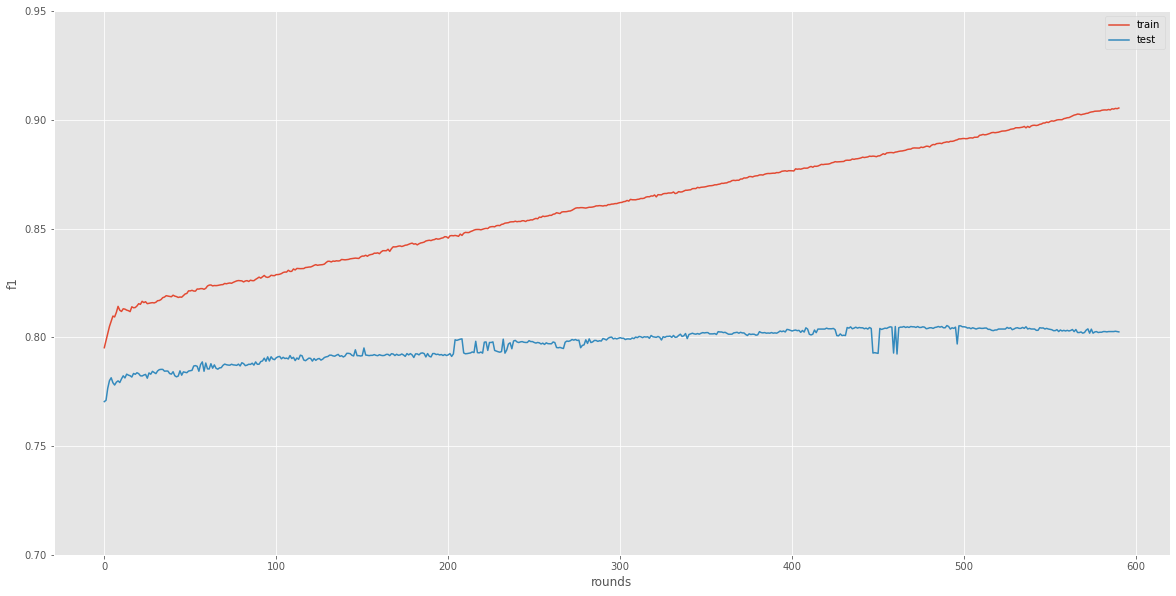

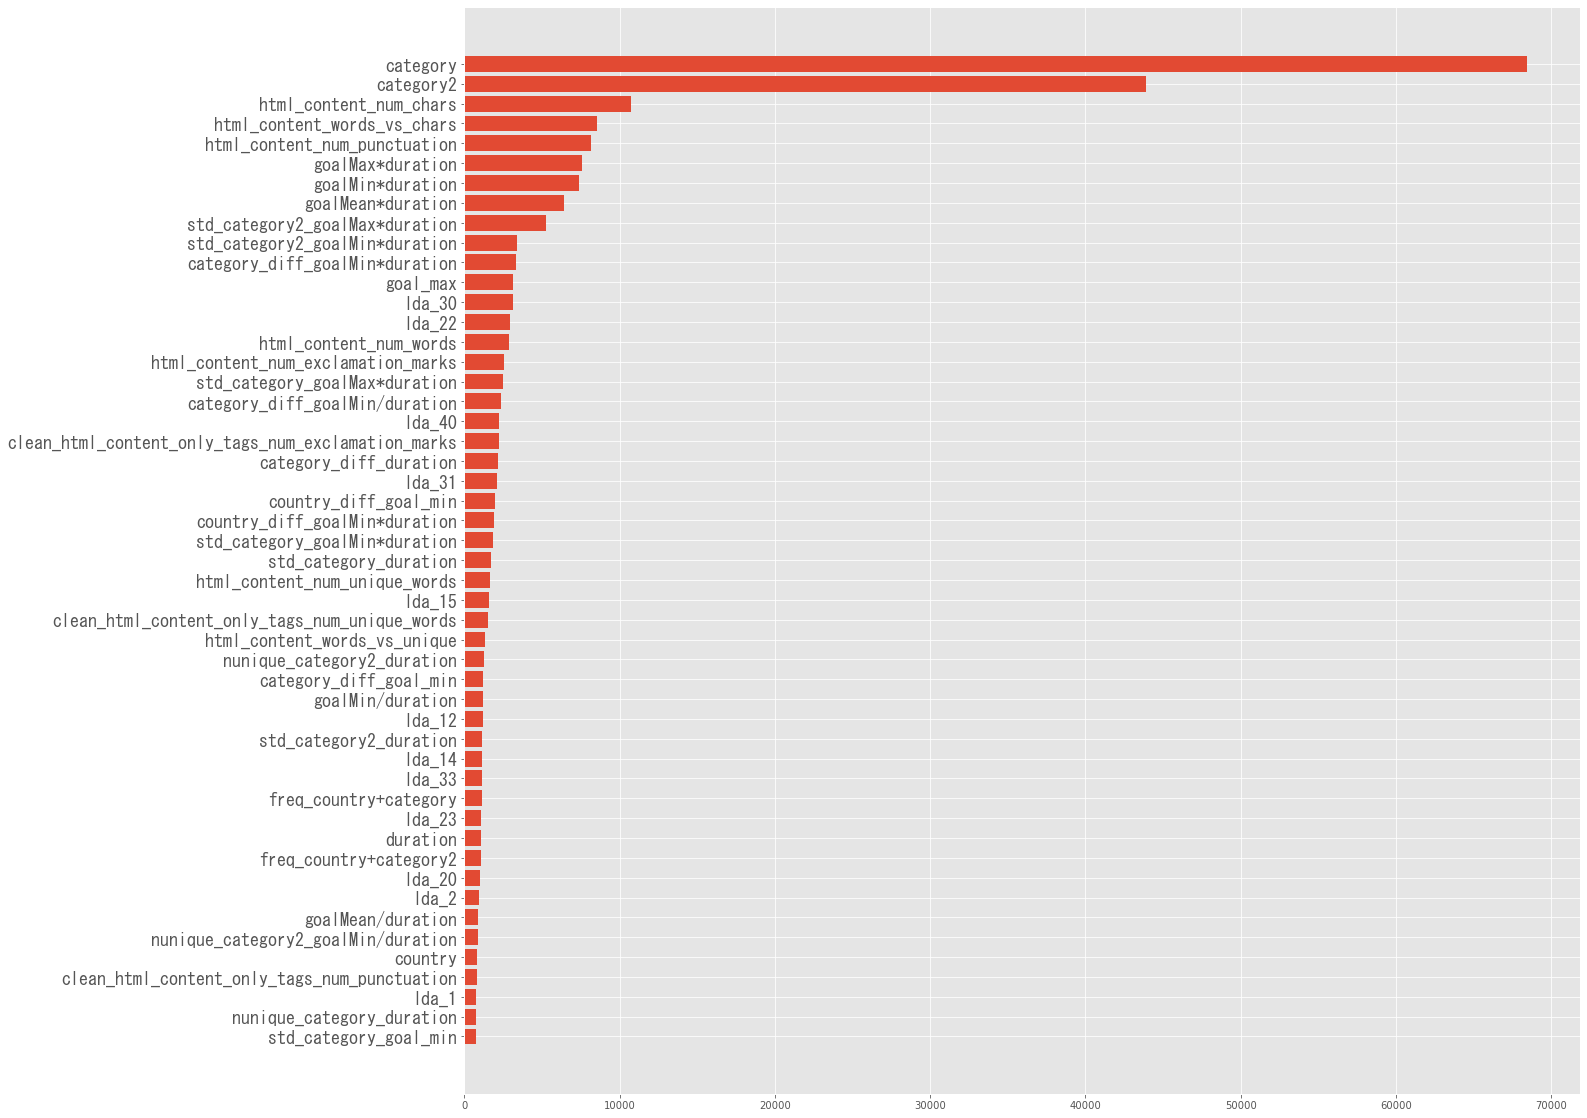

In [88]:
# 学習中の評価結果を取り出す
eval_results = lgb_normal.evals_result_
train_metrics = eval_results["training"]["f1"]
test_metrics = eval_results["valid_1"]["f1"]

# 学習曲線をプロット
plt.figure(figsize=(20, 10))

plt.plot(train_metrics)
plt.plot(test_metrics)

plt.legend(["train", "test"])
plt.xlabel('rounds')
plt.ylabel('f1')
plt.ylim(0.7, 0.95)
plt.show()

# 特徴量の重要度を抽出
importances = lgb_normal.feature_importances_
# 重要度の降順で元のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 上位40個の重要度
indices_selected = indices[:50]
# 特徴量の重要度をプロット
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.barh(range(indices_selected.shape[0]), importances[indices_selected])
plt.yticks(range(indices_selected.shape[0]), X.columns[indices_selected], fontname="MS Gothic", fontsize=18)
ax.invert_yaxis()
plt.show()

In [92]:
# スコア
scores = cv_score_GB_tar(lgb_normal, X, early_stopping_rounds=100)
print(scores)
print(np.mean(scores), np.std(scores))

[0.7798036465638148, 0.7845355964167845, 0.7938432835820896, 0.795668549905838, 0.7865796831314072]
0.7880861519199869 0.005901069593860561


### パラメータチューニング

In [93]:
# hyperoptを使ったパラメータ探索

In [94]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import log_loss

In [98]:
# パラメータを引数にとり、評価を返す関数を定義

def score(space):
    classifier = lgb.LGBMClassifier(n_estimators = 3000,                                   
                                    learning_rate = 0.01,
                                    max_depth = int(space['max_depth']),                                   
                                    min_child_weight = space['min_child_weight'],
                                    num_leaves = int(space['num_leaves']),
                                    subsample = space['subsample'],
                                    colsample_bytree = space['colsample_bytree'],
                                    reg_alpha = space['reg_alpha'],
                                    reg_lambda = space['reg_lambda'],
                                    random_state=111,
                                   )
    # 1-fold
    tr_x = tr_x_dict["fold_{}".format(0)]
    va_x = va_x_dict["fold_{}".format(0)]
    tr_y = tr_y_dict["fold_{}".format(0)]
    va_y = va_y_dict["fold_{}".format(0)]
    classifier.fit(tr_x,
                   tr_y,
                   eval_set=[(tr_x, tr_y), (va_x, va_y)], 
                   early_stopping_rounds=100,
                   verbose=False)
    va_pred = classifier.predict(va_x)
    score = f1_score(va_pred, va_y)
    
    # Cross Validation
#     scores = cv_score_GB_tar(classifier, early_stopping_rounds=100)
#     score = np.mean(scores)
    
    print(f'params: {space}, f1: {score:.4f}')

    # 情報を記録しておく
    history.append((space, score))

    return{'loss':1-score, 'status': STATUS_OK }

In [99]:
%%time

# 探索するパラメータの空間を指定する
space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    "num_leaves": hp.quniform('num_leaves', 30, 120, 2),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'reg_alpha' : hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
    'reg_lambda' : hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0)),
}

# hyperoptによるパラメータ探索の実行
max_evals = 10
trials = Trials()
history = []
fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 記録した情報からパラメータとスコアを出力する
history = sorted(history, key=lambda tpl: tpl[1], reverse=True)
best = history[0]
print()
print(f'best params:{best[0]}, score:{best[1]:.4f}')

params: {'colsample_bytree': 0.75, 'max_depth': 7.0, 'min_child_weight': 0.14078562730987704, 'num_leaves': 50.0, 'reg_alpha': 0.00014013391020459615, 'reg_lambda': 0.05281091905097486, 'subsample': 0.9}, f1: 0.7823
params: {'colsample_bytree': 0.75, 'max_depth': 7.0, 'min_child_weight': 9.912866222229141, 'num_leaves': 116.0, 'reg_alpha': 2.1286122572693673e-05, 'reg_lambda': 0.7215158491517537, 'subsample': 0.75}, f1: 0.7815
params: {'colsample_bytree': 0.7000000000000001, 'max_depth': 9.0, 'min_child_weight': 5.563733856374147, 'num_leaves': 38.0, 'reg_alpha': 0.05256002183927093, 'reg_lambda': 2.961017377736614, 'subsample': 0.8500000000000001}, f1: 0.7817
params: {'colsample_bytree': 0.6000000000000001, 'max_depth': 6.0, 'min_child_weight': 5.499367665569831, 'num_leaves': 58.0, 'reg_alpha': 0.0490850193053766, 'reg_lambda': 0.8034699899208446, 'subsample': 0.8}, f1: 0.7858
params: {'colsample_bytree': 0.8, 'max_depth': 4.0, 'min_child_weight': 0.45418204893580566, 'num_leaves': 1

### re-modeling

In [100]:
best_lgb = best[0]

In [101]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.05,
                               n_estimators=2000,
                               random_state=7,
                               n_jobs=-1,
                               importance_type="total_gain",
                               max_depth=int(best_lgb["max_depth"]), 
                               num_leaves=int(best_lgb["num_leaves"]),
                               colsample_bytree=best_lgb["colsample_bytree"],
                               subsample=best_lgb["subsample"],
                               reg_lambda=best_lgb["reg_lambda"],
                               reg_alpha=best_lgb["reg_alpha"],
                               min_child_weight=best_lgb["min_child_weight"],                           
                              )

## XGBoost

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

xgb_normal = xgb.XGBClassifier(learning_rate=0.01,
                              n_estimators=2000,
                              max_depth=3, 
                              colsample_bytree=1.0,
                              colsample_bylevel=0.3,
                              subsample=0.9,
                              gamma=0,
                              reg_lambda=1,
                              reg_alpha=0,
                              min_child_weight=1,                             
                              random_state=7,
                              n_jobs=-1,
                              importance_type="total_gain",
                             )
xgb_normal.fit(X_train,
               y_train, 
               #eval_metric=optimized_f1,
               eval_set=[(X_train, y_train), (X_test, y_test)], 
               early_stopping_rounds=100)

[0]	validation_0-error:0.25797	validation_1-error:0.25446
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.26644	validation_1-error:0.26963
[2]	validation_0-error:0.24659	validation_1-error:0.24573
[3]	validation_0-error:0.24191	validation_1-error:0.24687
[4]	validation_0-error:0.24393	validation_1-error:0.25028
[5]	validation_0-error:0.24140	validation_1-error:0.24915
[6]	validation_0-error:0.24153	validation_1-error:0.24953
[7]	validation_0-error:0.24431	validation_1-error:0.25142
[8]	validation_0-error:0.24418	validation_1-error:0.25256
[9]	validation_0-error:0.23976	validation_1-error:0.24005
[10]	validation_0-error:0.24583	validation_1-error:0.25218
[11]	validation_0-error:0.24014	validation_1-error:0.24346
[12]	validation_0-error:0.24165	validation_1-error:0.24687
[13]	validation_0-error:0.24089	validation_1-error:0.24611
[14]	validation_0-erro

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='total_gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, num_parallel_tree=1, random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

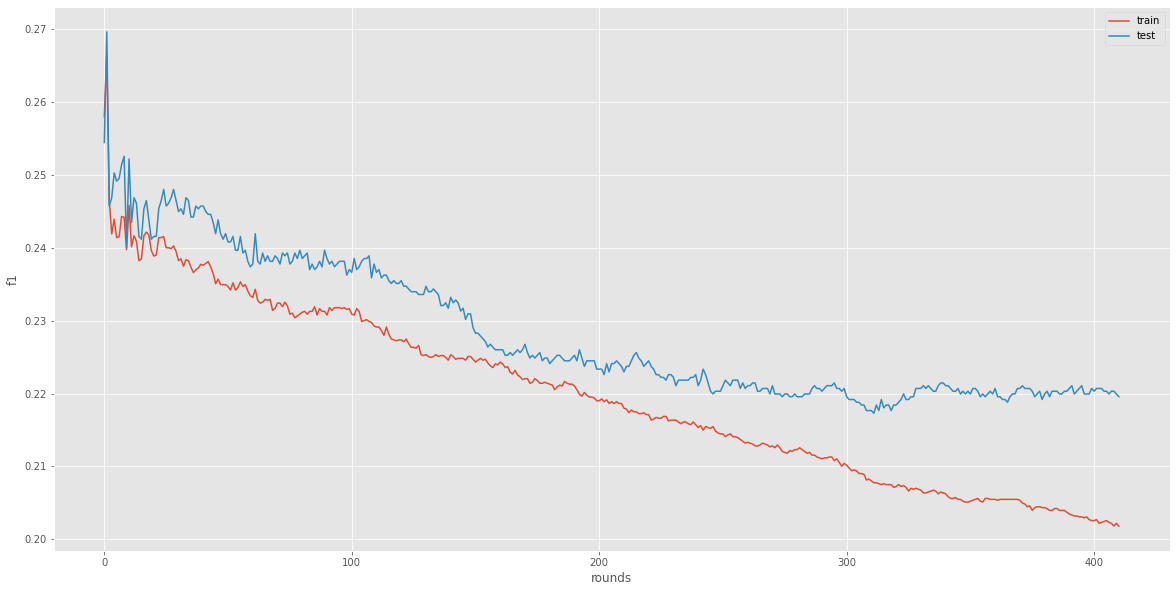

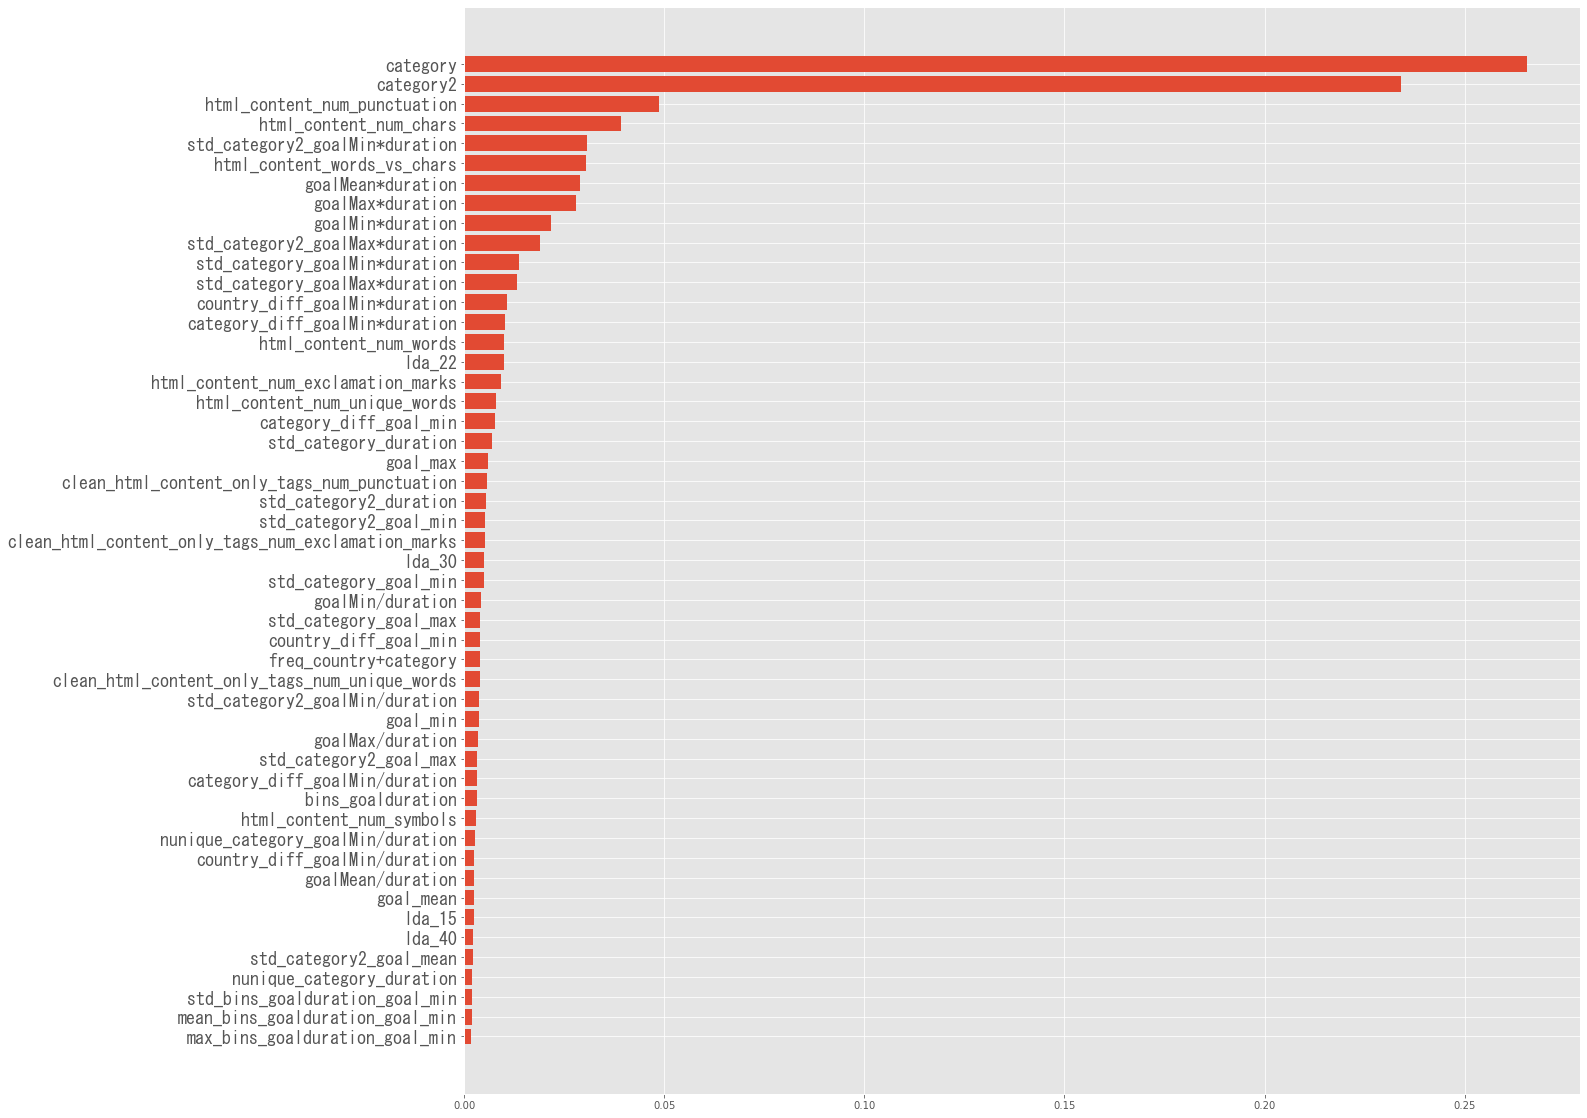

In [103]:
# 学習中の評価結果を取り出す
eval_results = xgb_normal.evals_result_
train_metrics = eval_results["validation_0"]["error"]
test_metrics = eval_results["validation_1"]["error"]

# 学習曲線をプロット
plt.figure(figsize=(20, 10))

plt.plot(train_metrics)
plt.plot(test_metrics)

plt.legend(["train", "test"])
plt.xlabel('rounds')
plt.ylabel('f1')
#plt.ylim(0.7, 0.95)
plt.show()


# 特徴量の重要度を抽出
importances = xgb_normal.feature_importances_
# 重要度の降順で元のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 上位40個の重要度
indices_selected = indices[:50]
# 特徴量の重要度をプロット
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.barh(range(indices_selected.shape[0]), importances[indices_selected])
plt.yticks(range(indices_selected.shape[0]), X.columns[indices_selected], fontname="MS Gothic", fontsize=18)
ax.invert_yaxis()
plt.show()

In [105]:
# スコア
scores = cv_score_GB_tar(xgb_normal, X,  eval_metric=None, early_stopping_rounds=100)
print(scores)
print(np.mean(scores), np.std(scores))

[0.7840707964601771, 0.7935368043087973, 0.7946157186278768, 0.7883853937527496, 0.7854609929078014]
0.7892139412114804 0.00422112294084761


### パラメータチューニング

In [106]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import log_loss

In [107]:
# hyperoptを使ったパラメータ探索

def score(space):
    classifier = xgb.XGBClassifier(n_estimators = 2000,                                   
                                   learning_rate = 0.05,
                                   max_depth = int(space['max_depth']),                                   
                                   min_child_weight = space['min_child_weight'],
                                   subsample = space['subsample'],
                                   colsample_bytree = space['colsample_bytree'],
                                   gamma = space['gamma'],
                                   reg_alpha = space['reg_alpha'],
                                   reg_lambda = space['reg_lambda'],
                                   random_state=111,
                                  )
    # 1-fold
    tr_x = tr_x_dict["fold_{}".format(1)]
    va_x = va_x_dict["fold_{}".format(1)]
    tr_y = tr_y_dict["fold_{}".format(1)]
    va_y = va_y_dict["fold_{}".format(1)]
    classifier.fit(tr_x,
                   tr_y,
                   eval_set=[(tr_x, tr_y), (va_x, va_y)], 
                   early_stopping_rounds=100,
                   verbose=False)
    va_pred = classifier.predict(va_x)
    score = f1_score(va_pred, va_y)
    
        # Cross Validation
#     scores = cv_score_GB_tar(classifier, early_stopping_rounds=100)
#     score = np.mean(scores)
    
    print(f'params: {space}, f1: {score:.4f}')

    # 情報を記録しておく
    history.append((space, score))

    return{'loss':1-score, 'status': STATUS_OK }

In [108]:
%%time

# 探索するパラメータの空間を指定する
space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
    # 余裕があればalpha, lambdaも調整する
    'reg_alpha' : hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
    'reg_lambda' : hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0)),
}

# hyperoptによるパラメータ探索の実行
max_evals = 10
trials = Trials()
history = []
fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 記録した情報からパラメータとスコアを出力する
history = sorted(history, key=lambda tpl: tpl[1], reverse=True)
best = history[0]
print()
print(f'best params:{best[0]}, score:{best[1]:.4f}')

params: {'colsample_bytree': 0.75, 'gamma': 5.34243383483575e-08, 'max_depth': 5.0, 'min_child_weight': 1.1362877717802293, 'reg_alpha': 0.6538278239588348, 'reg_lambda': 0.0016649180580752545, 'subsample': 0.9}, f1: 0.7857
params: {'colsample_bytree': 0.8, 'gamma': 0.029339404050561325, 'max_depth': 7.0, 'min_child_weight': 0.19335993004263785, 'reg_alpha': 0.007047723180020446, 'reg_lambda': 0.23173313150727945, 'subsample': 0.75}, f1: 0.7775
params: {'colsample_bytree': 0.8, 'gamma': 2.6075508598490707e-07, 'max_depth': 9.0, 'min_child_weight': 4.631987575497699, 'reg_alpha': 0.22684918029720186, 'reg_lambda': 1.3439429644957872e-06, 'subsample': 0.7000000000000001}, f1: 0.7842
params: {'colsample_bytree': 0.8, 'gamma': 0.0003919963428842725, 'max_depth': 4.0, 'min_child_weight': 0.11258736210565515, 'reg_alpha': 0.03149073330732924, 'reg_lambda': 0.0002129973262181042, 'subsample': 0.8500000000000001}, f1: 0.7868
params: {'colsample_bytree': 0.8, 'gamma': 3.7340420445786233e-07, 'm

### re-modeling

In [109]:
best_xgb = best

In [110]:
xgb_model = xgb.XGBClassifier(learning_rate=0.05,
                               n_estimators=2000,
                               random_state=7,
                               n_jobs=-1,
                               importance_type="total_gain",
                               max_depth=int(best_xgb[0]["max_depth"]), 
                               colsample_bytree=best_xgb[0]["colsample_bytree"],
                               subsample=best_xgb[0]["subsample"],
                               gamma=best_xgb[0]["gamma"],
                               reg_lambda=best_xgb[0]["reg_lambda"],
                               reg_alpha=best_xgb[0]["reg_alpha"],
                               min_child_weight=best_xgb[0]["min_child_weight"],                           
                              )

## 特徴量選択

In [111]:
# 特徴量選択
X_selected = X[X.columns[indices[:30]]] # 残す特徴量の数を指定
test_selected = test[X_selected.columns]
X_selected.shape

(10545, 30)

In [113]:
# スコア
scores = cv_score_GB_tar(lgb_normal, X_selected, early_stopping_rounds=100)
print(scores)
print(np.mean(scores), np.std(scores))

[0.7880143112701252, 0.7803065490013934, 0.7973094170403586, 0.7870544090056285, 0.7968963943404839]
0.789916216131598 0.006442595625782862


### パラメータチューニング

In [114]:
# hyperoptを使ったパラメータ探索

def score(space):
    classifier = lgb.LGBMClassifier(n_estimators = 3000,                                   
                                    learning_rate = 0.01,
                                    max_depth = int(space['max_depth']),                                   
                                    min_child_weight = space['min_child_weight'],
                                    num_leaves = int(space['num_leaves']),
                                    subsample = space['subsample'],
                                    colsample_bytree = space['colsample_bytree'],
                                    reg_alpha = space['reg_alpha'],
                                    reg_lambda = space['reg_lambda'],
                                    random_state=111,
                                   )
    # 1-fold
    tr_x = tr_x_dict["fold_{}".format(3)][X_selected.columns]
    va_x = va_x_dict["fold_{}".format(3)][X_selected.columns]
    tr_y = tr_y_dict["fold_{}".format(3)]
    va_y = va_y_dict["fold_{}".format(3)]
    classifier.fit(tr_x,
                   tr_y,
                   eval_set=[(tr_x, tr_y), (va_x, va_y)], 
                   early_stopping_rounds=100,
                   verbose=False)
    va_pred = classifier.predict(va_x)
    score = f1_score(va_pred, va_y)
    
        # Cross Validation
#     scores = cv_score_GB_tar(classifier, early_stopping_rounds=100)
#     score = np.mean(scores)
    
    print(f'params: {space}, f1: {score:.4f}')

    # 情報を記録しておく
    history.append((space, score))

    return{'loss':1-score, 'status': STATUS_OK }

In [115]:
%%time

# 探索するパラメータの空間を指定する
space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    "num_leaves": hp.quniform('num_leaves', 30, 120, 2),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    # 余裕があればalpha, lambdaも調整する
    'reg_alpha' : hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
    'reg_lambda' : hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0)),
}

# hyperoptによるパラメータ探索の実行
max_evals = 50
trials = Trials()
history = []
fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 記録した情報からパラメータとスコアを出力する
history = sorted(history, key=lambda tpl: tpl[1], reverse=True)
best = history[0]
print()
print(f'best params:{best[0]}, score:{best[1]:.4f}')

params: {'colsample_bytree': 0.9, 'max_depth': 4.0, 'min_child_weight': 3.528561535968936, 'num_leaves': 46.0, 'reg_alpha': 0.008494352380613798, 'reg_lambda': 2.0329795728963815, 'subsample': 0.9500000000000001}, f1: 0.7805
params: {'colsample_bytree': 0.65, 'max_depth': 9.0, 'min_child_weight': 0.22691116164134162, 'num_leaves': 98.0, 'reg_alpha': 1.930468913022703e-05, 'reg_lambda': 0.0019849535048909075, 'subsample': 0.7000000000000001}, f1: 0.7789
params: {'colsample_bytree': 0.9500000000000001, 'max_depth': 5.0, 'min_child_weight': 2.1078513492371203, 'num_leaves': 98.0, 'reg_alpha': 0.0034473184150022726, 'reg_lambda': 7.52320143420683e-06, 'subsample': 0.9}, f1: 0.7851
params: {'colsample_bytree': 0.65, 'max_depth': 9.0, 'min_child_weight': 2.1073199892009646, 'num_leaves': 68.0, 'reg_alpha': 0.13434789587769022, 'reg_lambda': 4.724933965466985e-05, 'subsample': 0.8500000000000001}, f1: 0.7818
params: {'colsample_bytree': 0.7000000000000001, 'max_depth': 5.0, 'min_child_weight'

In [116]:
best_lgb_select = best[0]

In [117]:
lgb_select_model = lgb.LGBMClassifier(learning_rate=0.01,
                                      n_estimators=3000,
                                      random_state=7,
                                      n_jobs=-1,
                                      importance_type="total_gain",
                                      max_depth=int(best_lgb_select["max_depth"]), 
                                      num_leaves=int(best_lgb_select["num_leaves"]),
                                      colsample_bytree=best_lgb_select["colsample_bytree"],
                                      subsample=best_lgb_select["subsample"],
                                      reg_lambda=best_lgb_select["reg_lambda"],
                                      reg_alpha=best_lgb_select["reg_alpha"],
                                      min_child_weight=best_lgb_select["min_child_weight"],                           
                                      )

## NN

In [118]:
import tensorflow as tf
from tensorflow import keras
from hyperopt import hp
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import ReLU, PReLU
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler

import os
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'

In [120]:
# スケーリング
scaler = StandardScaler()
normed_X = scaler.fit_transform(X)
normed_test = scaler.transform(test)

# モデル構築
np.random.seed(28)
tf.random.set_seed(73)

def buit_model():
    model = Sequential()
    
    model.add(Dense(96, activation="relu", input_shape=(normed_X.shape[1],)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(96, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(96, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))
    
    optimizer = Adam(learning_rate=0.00005)
    
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = buit_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                57600     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9

In [121]:
# モデルの学習
# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(normed_X, y,
                    batch_size=64,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stop])

Epoch 1/1000
149/149 [==============================] - 1s 9ms/step - loss: 0.7304 - accuracy: 0.5767 - val_loss: 0.6023 - val_accuracy: 0.6682
Epoch 2/1000
149/149 [==============================] - 1s 8ms/step - loss: 0.6680 - accuracy: 0.6293 - val_loss: 0.5673 - val_accuracy: 0.6882
Epoch 3/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.6298 - accuracy: 0.6649 - val_loss: 0.5478 - val_accuracy: 0.7166
Epoch 4/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.6071 - accuracy: 0.6838 - val_loss: 0.5323 - val_accuracy: 0.7374
Epoch 5/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.5873 - accuracy: 0.6974 - val_loss: 0.5256 - val_accuracy: 0.7327
Epoch 6/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.5703 - accuracy: 0.7064 - val_loss: 0.5189 - val_accuracy: 0.7431
Epoch 7/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.5615 - accuracy: 0.7194 - val_loss: 0.5124 - val_accuracy:

       loss  accuracy  val_loss  val_accuracy
0  0.730396  0.576712  0.602313      0.668246
1  0.667998  0.629294  0.567335      0.688152
2  0.629783  0.664910  0.547797      0.716588
3  0.607140  0.683772  0.532348      0.737441
4  0.587348  0.697366  0.525648      0.732701


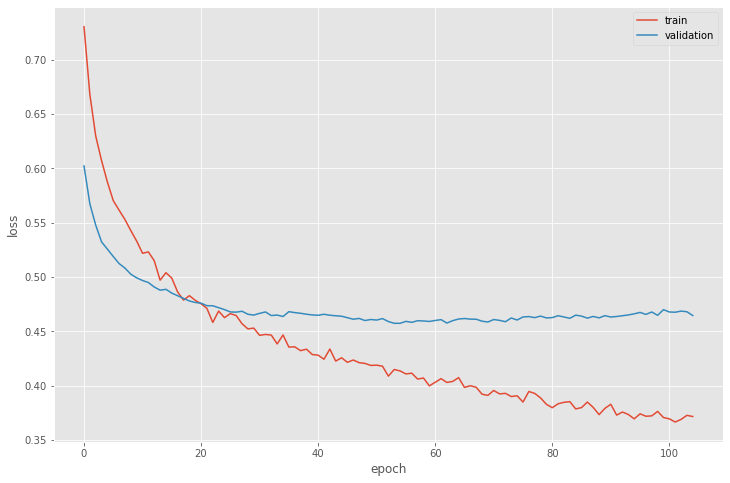

In [122]:
# 学習曲線
hist_df = pd.DataFrame(history.history)
print(hist_df.head())

# epochとスコアをプロット
plt.figure(figsize=(12,8))
plt.plot(hist_df["loss"], label="train")
plt.plot(hist_df["val_loss"], label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### パラメータチューニング

In [123]:
# fitで学習し、predictで予測確率を返すクラスを定義
class MLP:

    def __init__(self, params):
        self.params = params
        self.scaler = None
        self.model = None

    def fit(self, tr_x, tr_y, test_x):

        # パラメータ
        input_dropout = self.params['input_dropout']
        hidden_layers = int(self.params['hidden_layers'])
        hidden_units = int(self.params['hidden_units'])
        hidden_activation = self.params['hidden_activation']
        hidden_dropout = self.params['hidden_dropout']
        batch_norm = self.params['batch_norm']
        optimizer_type = self.params['optimizer']['type']
        optimizer_lr = self.params['optimizer']['lr']
        batch_size = int(self.params['batch_size'])

        # 標準化
        self.scaler = StandardScaler().fit(pd.concat([tr_x, test_x]))
        tr_x = self.scaler.transform(tr_x)

        self.model = Sequential()

        # 入力層
        self.model.add(Dropout(input_dropout, input_shape=(tr_x.shape[1],)))

        # 中間層
        for i in range(hidden_layers):
            self.model.add(Dense(hidden_units))
            if batch_norm == 'before_act':
                self.model.add(BatchNormalization())
            if hidden_activation == 'prelu':
                self.model.add(PReLU())
            elif hidden_activation == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(hidden_dropout))

        # 出力層
        self.model.add(Dense(1, activation='sigmoid'))

        # オプティマイザ
        if optimizer_type == 'sgd':
            optimizer = SGD(lr=optimizer_lr, decay=1e-6, momentum=0.9, nesterov=True)
        elif optimizer_type == 'adam':
            optimizer = Adam(lr=optimizer_lr, beta_1=0.9, beta_2=0.999, decay=0.)
        else:
            raise NotImplementedError

        # 目的関数、評価指標などの設定
        self.model.compile(loss='binary_crossentropy',
                           optimizer=optimizer, metrics=['accuracy'])

        # エポック数、アーリーストッピング
        # あまりepochを大きくすると、小さい学習率のときに終わらないことがあるので注意
        nb_epoch = 1000
        patience = 50
        early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

        # 学習の実行
        history = self.model.fit(tr_x, tr_y,
                                 epochs=nb_epoch,
                                 batch_size=batch_size,
                                 verbose=0,
                                 validation_split=0.1,
                                 callbacks=[early_stopping])

    def predict(self, x):
        # 予測
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred

In [128]:
# パラメータを与えたときに、評価指標を返す関数を定義
from hyperopt import fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import log_loss

def score(params):
    
    # 1-fold
    tr_x = tr_x_dict["fold_{}".format(2)]
    va_x = va_x_dict["fold_{}".format(2)]
    tr_y = tr_y_dict["fold_{}".format(2)]
    va_y = va_y_dict["fold_{}".format(2)]
    
    model = MLP(params)
    model.fit(tr_x, tr_y, va_x)
    va_pred = model.predict(va_x)
    score = log_loss(va_y, va_pred)
    print(f'params: {params}, logloss: {score:.4f}')

    # 情報を記録しておく
    history.append((params, score))

    return {'loss': score, 'status': STATUS_OK}

In [129]:
%%time

# パラメータ空間
space = {
    'input_dropout': hp.quniform('input_dropout', 0, 0.2, 0.05),
    'hidden_layers': hp.quniform('hidden_layers', 2, 4, 1),
    'hidden_units': hp.quniform('hidden_units', 32, 256, 32),
    'hidden_activation': hp.choice('hidden_activation', ['prelu', 'relu']),
    'hidden_dropout': hp.quniform('hidden_dropout', 0, 0.3, 0.05),
    'batch_norm': hp.choice('batch_norm', ['before_act', 'no']),
    'optimizer': hp.choice('optimizer', [{'type': 'adam', 'lr': 0.00005}, {'type': 'sgd', 'lr': 0.00005}]),
    'batch_size': hp.quniform('batch_size', 32, 128, 32),
}

# パラメータ探索の実行
max_evals = 10
trials = Trials()
history = []
fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 記録した情報からパラメータとスコアを出力する
history = sorted(history, key=lambda tpl: tpl[1])
best = history[0]
print()
print(f'best params:{best[0]}, score:{best[1]:.4f}')

params: {'batch_norm': 'before_act', 'batch_size': 96.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.30000000000000004, 'hidden_layers': 2.0, 'hidden_units': 64.0, 'input_dropout': 0.05, 'optimizer': {'lr': 5e-05, 'type': 'adam'}}, logloss: 0.4399
params: {'batch_norm': 'no', 'batch_size': 64.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.1, 'hidden_layers': 3.0, 'hidden_units': 64.0, 'input_dropout': 0.2, 'optimizer': {'lr': 5e-05, 'type': 'sgd'}}, logloss: 0.4452
params: {'batch_norm': 'before_act', 'batch_size': 64.0, 'hidden_activation': 'relu', 'hidden_dropout': 0.25, 'hidden_layers': 3.0, 'hidden_units': 32.0, 'input_dropout': 0.1, 'optimizer': {'lr': 5e-05, 'type': 'adam'}}, logloss: 0.4423
params: {'batch_norm': 'before_act', 'batch_size': 128.0, 'hidden_activation': 'relu', 'hidden_dropout': 0.1, 'hidden_layers': 3.0, 'hidden_units': 256.0, 'input_dropout': 0.2, 'optimizer': {'lr': 5e-05, 'type': 'sgd'}}, logloss: 0.4556
params: {'batch_norm': 'before_act', 'batch_

### re-modeling

In [130]:
best_nn = best[0]

nn_model = MLP(best_nn)

## 全てLabel Eccodingの場合

In [132]:
# Label Eccoding
from sklearn.preprocessing import LabelEncoder

all_df_label = all_df.copy().drop(columns=["id", "goal", "html_content"])
cols = all_df_label.columns[(all_df_label.dtypes=="object") | (all_df_label.dtypes=="bool")]
lb = LabelEncoder()
for col in cols:
    all_df_label[col] = lb.fit_transform(all_df_label[col])

# データ分割
train_label = all_df_label[all_df_label["state"].notnull()]
test_label = all_df_label[all_df_label["state"].isnull()].drop(columns=["state"])

X_label = train_label.drop(columns=["state"])
y_label = train_label["state"]

### パラメータチューニング

In [133]:
# hyperoptを使ったパラメータ探索

def score(space):
    classifier = lgb.LGBMClassifier(n_estimators = 3000,                                   
                                    learning_rate = 0.01,
                                    max_depth = int(space['max_depth']),                                   
                                    min_child_weight = space['min_child_weight'],
                                    num_leaves = int(space['num_leaves']),
                                    subsample = space['subsample'],
                                    colsample_bytree = space['colsample_bytree'],
                                    reg_alpha = space['reg_alpha'],
                                    reg_lambda = space['reg_lambda'],
                                    random_state=111,
                                   )
    # 1-fold
    tr_x, va_x, tr_y, va_y = train_test_split(X_label, y, random_state=9)
    classifier.fit(tr_x,
                   tr_y,
                   eval_set=[(tr_x, tr_y), (va_x, va_y)], 
                   early_stopping_rounds=100,
                   verbose=False)
    va_pred = classifier.predict(va_x)
    score = f1_score(va_pred, va_y)
    
        # Cross Validation
#     scores = cv_score_GB_tar(classifier, early_stopping_rounds=100)
#     score = np.mean(scores)
    
    print(f'params: {space}, f1: {score:.4f}')

    # 情報を記録しておく
    history.append((space, score))

    return{'loss':1-score, 'status': STATUS_OK }

In [136]:
%%time

# 探索するパラメータの空間を指定する
space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    "num_leaves": hp.quniform('num_leaves', 30, 120, 2),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    # 余裕があればalpha, lambdaも調整する
    'reg_alpha' : hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
    'reg_lambda' : hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0)),
}

# hyperoptによるパラメータ探索の実行
max_evals = 10
trials = Trials()
history = []
fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 記録した情報からパラメータとスコアを出力する
history = sorted(history, key=lambda tpl: tpl[1], reverse=True)
best = history[0]
print()
print(f'best params:{best[0]}, score:{best[1]:.4f}')

params: {'colsample_bytree': 0.8, 'max_depth': 8.0, 'min_child_weight': 9.227793506752452, 'num_leaves': 118.0, 'reg_alpha': 1.5900636239601412e-06, 'reg_lambda': 1.0653158609626023, 'subsample': 0.9}, f1: 0.7830
params: {'colsample_bytree': 0.65, 'max_depth': 5.0, 'min_child_weight': 3.4447713538639233, 'num_leaves': 74.0, 'reg_alpha': 8.195199865766895e-08, 'reg_lambda': 0.3745353867467687, 'subsample': 0.9}, f1: 0.7826
params: {'colsample_bytree': 0.8500000000000001, 'max_depth': 7.0, 'min_child_weight': 0.8143252707241523, 'num_leaves': 90.0, 'reg_alpha': 0.0073470498638121716, 'reg_lambda': 0.037990156008786934, 'subsample': 0.9}, f1: 0.7802
params: {'colsample_bytree': 0.75, 'max_depth': 5.0, 'min_child_weight': 0.29874205081270633, 'num_leaves': 86.0, 'reg_alpha': 4.334143341571856e-06, 'reg_lambda': 6.09486440842375, 'subsample': 0.9500000000000001}, f1: 0.7843
params: {'colsample_bytree': 0.75, 'max_depth': 6.0, 'min_child_weight': 1.3802519529423167, 'num_leaves': 76.0, 'reg_

### modeling

In [137]:
best_lgb_label = best[0]

lgb_label_model = lgb.LGBMClassifier(learning_rate=0.05,
                                     n_estimators=2000,
                                     random_state=7,
                                     n_jobs=-1,
                                     importance_type="total_gain",
                                     max_depth=int(best_lgb_label["max_depth"]), 
                                     num_leaves=int(best_lgb_label["num_leaves"]),
                                     colsample_bytree=best_lgb_label["colsample_bytree"],
                                     subsample=best_lgb_label["subsample"],
                                     reg_lambda=best_lgb_label["reg_lambda"],
                                     reg_alpha=best_lgb_label["reg_alpha"],
                                     min_child_weight=best_lgb_label["min_child_weight"],                           
                                    )

## スタッキング

### モデルを整形する
fitで学習し、predictで予測値の確率を出力するクラスを作る

In [138]:
# fitで学習し、predictで予測値の確率を出力するクラスにする

# lightgbmによるモデル
class Model_Lgb:

    def __init__(self):
        self.model = None

    def fit(self, tr_x, tr_y, test):
        X_train, X_test, y_train, y_test = train_test_split(tr_x, tr_y, random_state=2)
        model = lgb_model
        model.fit(X_train,
                  y_train, 
                  #eval_metric=,
                  eval_set=[(X_train, y_train), (X_test, y_test)], 
                  early_stopping_rounds=100,
                  verbose=0)
        
        self.model = model

    def predict(self, x):
        pred = self.model.predict_proba(x)[:,1]
        return pred
    

# xgboostによるモデル
class Model_Xgb:

    def __init__(self):
        self.model = None

    def fit(self, tr_x, tr_y, test):
        X_train, X_test, y_train, y_test = train_test_split(tr_x, tr_y, random_state=1)
        model = xgb_model
        model.fit(X_train,
                  y_train, 
                  #eval_metric=,
                  eval_set=[(X_train, y_train), (X_test, y_test)], 
                  early_stopping_rounds=100,
                  verbose=0)

        self.model = model

    def predict(self, x):
        pred = self.model.predict_proba(x)[:,1]
        return pred


# 特徴量選択によるモデル
class Model_Lgb_Select:

    def __init__(self):
        self.model = None

    def fit(self, tr_x_selected, tr_y, test):
        X_train, X_test, y_train, y_test = train_test_split(tr_x_selected, tr_y, random_state=3)
        model = lgb_select_model
        model.fit(X_train,
                  y_train, 
                  #eval_metric=,
                  eval_set=[(X_train, y_train), (X_test, y_test)], 
                  early_stopping_rounds=100,
                  verbose=0)
        
        self.model = model

    def predict(self, x_selected):
        pred = self.model.predict_proba(x_selected)[:,1]
        return pred

# ニューラルネットによるモデル
class Model_NN:

    def __init__(self):
        self.model = None

    def fit(self, tr_x, tr_y, test):
        model = nn_model
        model.fit(tr_x, tr_y, test)
        self.model = model

    def predict(self, x):
        pred = self.model.predict(x).reshape(-1)
        return pred
    
# 全てラベルエンコーディングのLGBモデル
class Model_Label:

    def __init__(self):
        self.model = None

    def fit(self, tr_x_label, tr_y, test):
        X_train, X_test, y_train, y_test = train_test_split(tr_x_label, tr_y, random_state=90)
        model = lgb_label_model
        model.fit(X_train,
                  y_train, 
                  #eval_metric=,
                  eval_set=[(X_train, y_train), (X_test, y_test)], 
                  early_stopping_rounds=100,
                  verbose=0)
        
        self.model = model

    def predict(self, x_label):
        pred = self.model.predict_proba(x_label)[:,1]
        return pred
    

# Logistic Regressionによるモデル（２層目）
class Model_LG:

    def __init__(self):
        self.model = None
        self.scaler = None

    def fit(self, tr_x, tr_y, test):
        self.scaler = StandardScaler()
        self.scaler.fit(tr_x)
        tr_x = self.scaler.transform(tr_x)
        self.model = LogisticRegression(solver='lbfgs', C=0.01)
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        x = self.scaler.transform(x)
        pred = self.model.predict_proba(x)[:, 1]
        return pred


### 「目的変数を知らない」予測値を返す関数

In [139]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
# modelは、fitで学習し、predictで予測値の確率を出力する
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, test)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test

### スタッキングの実行

In [140]:
%%time

# 1層目のモデル
# pred_train_1は、学習データのクロスバリデーションでの予測値
# pred_test_1は、テストデータの予測値
model_1a = Model_Lgb()
pred_train_1a, pred_test_1a = predict_cv(model_1a, X, y, test)

model_1b = Model_Xgb()
pred_train_1b, pred_test_1b = predict_cv(model_1b, X, y, test)

model_1c = Model_Lgb_Select()
pred_train_1c, pred_test_1c = predict_cv(model_1c, X_selected, y, test_selected)

model_1d = Model_NN()
pred_train_1d, pred_test_1d = predict_cv(model_1d, X, y, test)

model_1e = Model_Label()
pred_train_1e, pred_test_1e = predict_cv(model_1e, X_label, y, test_label)


# 1層目のモデルの評価
print(f'logloss: {log_loss(y, pred_train_1a, eps=1e-7):.4f}')
print(f'logloss: {log_loss(y, pred_train_1b, eps=1e-7):.4f}')
print(f'logloss: {log_loss(y, pred_train_1c, eps=1e-7):.4f}')
print(f'logloss: {log_loss(y, pred_train_1d, eps=1e-7):.4f}')
print(f'logloss: {log_loss(y, pred_train_1e, eps=1e-7):.4f}')

# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a,
                          'pred_1b': pred_train_1b,
                          'pred_1c': pred_train_1c,                                                    
                          "pred_1d": pred_train_1d,
                          "pred_1e": pred_train_1e,
                         })
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a,
                         'pred_1b': pred_test_1b, 
                         'pred_1c': pred_test_1c,
                         'pred_1d': pred_test_1d,
                         'pred_1e': pred_test_1e,
                        })

# 2層目のモデル
# pred_train_2は、2層目のモデルの学習データのクロスバリデーションでの予測値
# pred_test_2は、2層目のモデルのテストデータの予測値
model_2 = Model_LG()
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, y, test_x_2)

print()
print(f'logloss: {log_loss(y, pred_train_2, eps=1e-7):.4f}')

logloss: 0.4238
logloss: 0.4349
logloss: 0.4312
logloss: 0.4414
logloss: 0.4338

logloss: 0.4309
Wall time: 5min 31s


### 交差検証

In [147]:
# fitと確率予測が出来るスタックモデルを定義
class Model_Stack:

    def __init__(self):
        self.model = None
        self.pred_train_2 = None
        self.pred_test_2 = None

    def fit_predict(self, X, y, test, X_selected, test_selected, X_label, test_label): # モデルを追加した場合は要変更
        
        # 1層目
        model_1a = Model_Lgb()
        pred_train_1a, pred_test_1a = predict_cv(model_1a, X, y, test)

        model_1b = Model_Xgb()
        pred_train_1b, pred_test_1b = predict_cv(model_1b, X, y, test)

        model_1c = Model_Lgb_Select()
        pred_train_1c, pred_test_1c = predict_cv(model_1c, X_selected, y, test_selected)

        model_1d = Model_NN()
        pred_train_1d, pred_test_1d = predict_cv(model_1d, X, y, test)

        model_1e = Model_Label()
        pred_train_1e, pred_test_1e = predict_cv(model_1e, X_label, y, test_label)

        # 予測値を特徴量としてデータフレームを作成
        train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a,
                                  'pred_1b': pred_train_1b,
                                  'pred_1c': pred_train_1c,                                                    
                                  "pred_1d": pred_train_1d,
                                  "pred_1e": pred_train_1e,
                                 })
        test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a,
                                 'pred_1b': pred_test_1b, 
                                 'pred_1c': pred_test_1c,
                                 'pred_1d': pred_test_1d,
                                 'pred_1e': pred_test_1e,
                                })

        # 2層目
        model_2 = Model_LG()
        pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, y, test_x_2)
        
        self.pred_train_2 = pred_train_2
        self.pred_test_2 = pred_test_2
        
        return self.pred_train_2, self.pred_test_2

In [148]:
# スタッキング用交差検証
def cv_scorestack(model):
    scores = []
    for i in range(5):
        
        train_X = tr_x_dict["fold_{}".format(i)]
        valid_X = va_x_dict["fold_{}".format(i)]
        train_y = tr_y_dict["fold_{}".format(i)]
        valid_y = va_y_dict["fold_{}".format(i)]
        train_X_selected = train_X[X_selected.columns]
        valid_X_selected = valid_X[X_selected.columns]
        train_X_label = train_X[X_label.columns]
        valid_X_label = valid_X[X_label.columns]
        
        # 学習+予測確率の出力
        train_pred, valid_pred = model.fit_predict(train_X, train_y, valid_X, train_X_selected, valid_X_selected, train_X_label, valid_X_label) # モデルを追加した場合は要変更
        
        # 閾値探索
        best_threshold = threshold_opt(train_y, train_pred, f1_score)

        # スコアの計算・格納
        score = f1_score(valid_pred>=best_threshold, valid_y)
        scores.append(score)

    # 各foldのスコア
    return scores

In [149]:
%%time
scores = cv_scorestack(Model_Stack())
print(scores)
print(np.mean(scores), np.std(scores))

[0.7857802400738689, 0.7941952506596307, 0.8047285464098073, 0.8028169014084506, 0.7999999999999999]
0.7975041877103515 0.006856316460464044
Wall time: 41min 33s


In [157]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
10540    0.0
10541    0.0
10542    0.0
10543    1.0
10544    0.0
Name: state, Length: 10545, dtype: float64

## 閾値の最適化

In [159]:
# 真の値と予測確率
train_prob = pred_train_2

best_threshold = threshold_opt(y, train_prob, metrics=f1_score)

print("best_threshold: ", best_threshold)

best_threshold:  0.36269531249999987


In [160]:
init_score = f1_score(y, train_prob >= 0.5)
best_score = f1_score(y, train_prob >= best_threshold)
print("init: ", init_score)
print("best: ", best_score)

init:  0.7861359741001713
best:  0.7981442577030813


# 提出

In [161]:
# ラベル
labels = pred_test_2 >= best_threshold

In [162]:
submission = pd.read_csv(os.path.join("sample_submit.csv"), header=None)
submission[1] = labels.astype(int)
submission.to_csv("submission.csv", index=False, header=False)

In [163]:
submission

,0,1
0,10545,1
1,10546,1
2,10547,1
3,10548,0
4,10549,0
...,...,...
10539,21084,0
10540,21085,0
10541,21086,1
10542,21087,1
